In [233]:
%%HTML
<script src="require.js"></script>

In [234]:
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
HTML('''<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

In [24]:
import os
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.ml.feature import Bucketizer
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DecimalType
import numpy as np
import pandas as pd
import warnings
from typing import Iterator
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

In [25]:
spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', 'true') \
    .config("spark.driver.memory", "20g") \
    .appName("PySpark with RAPIDS") \
    .config("spark.rapids.memory.gpu.allocFraction", "0.25") \
    .config("spark.executor.resource.gpu.amount", "1") \
    .getOrCreate()
spark.sparkContext.setLogLevel('OFF')

In [26]:
spark = (SparkSession
         .builder
         .master('local[*]')
         .config('spark.sql.execution.arrow.pyspark.enabled', 'true')
         .getOrCreate())
spark.sparkContext.setLogLevel('OFF')

In [27]:
spark.conf.set("spark.sql.cbo.enabled", True)
spark.conf.set("spark.sql.cbo.joinReorder.enabled", True)
spark.conf.set("spark.sql.statistics.histogram.enabled", True)
spark.conf.set("spark.sql.tungsten.enabled", True)

In [28]:
def hex_to_decimal(hex_str):
    """
    Convert from hex to decimal.

    Parameters
    --------------
    hex_str : string
        Hexadecimal string

    Returns
    --------------
    string
        Decimal string
    """
    return str(int(hex_str, 16))
    
htd_udf = F.udf(hex_to_decimal, StringType())

In [29]:
@F.pandas_udf('string')
def bin_inputs(inputs: Iterator[pd.Series]) -> Iterator[pd.Series]:
    """Compute bins for input values

    Parameters
    --------------
    inputs : Iterator
        Iterator of Series

    Returns
    --------------
    Iterator
        Iterator of Series
    """
    n = 0
    for x in inputs:
        yield x.transform(lambda y: f"{int(y * 14) + 1} - {int(y * 14) + 14}")

<img src="images/bitcoin_poster.jpg">

<h1 style="color:#ffffff; background-color:#ffffff; padding: 20px 0; text-align: left; font-weight: bold; padding-left: 20px;"></h1>

<a id='Header2'></a>
<img src="images/abstract_bc.png">

Due to the exponential growth of the price of Bitcoin from 2018 to the early 2020, there is an impetus to analyze the pandemic-induced Bitcoin boom and its implications to Bitcoin users, taking into consideration other factors concerning the Bitcoin blockchain aside from price. Specifically, given the context of a Bitcoin boom, the study aims to provide effective guidance to buyers, sellers, miners, and the broader network so that the users may make better, informed decisions with regards to their personal investments in Bitcoin and so that the network may further improve on the adoption of its newly updated functionalities by its users.

The datasets used were the Bitcoin blockchain dataset in the form of compressed Parquet files which were sourced from the AWS Public Blockchain Dataset and the Bitcoin USD dataset in the form of a csv file which was sourced from Kaggle. Both were preprocessed and cleaned before being processed into data visualizations. Having filtered the Bitcoin blockchain dataset to be from 2018 to 2020 only, the authors then engineered different features such as lead time and amount transferred from the dataset and then visualized various sets of features from the datasets, in order to find possible relationships between these features.

On the network side, it was found that in the context of the Bitcoin boom, adoption of more updated address keys and versions were lagging. Alongside this issue, there is also the need for users to keep themselves abreast on global events and crypto-specific events, as these heavily affect the Bitcoin network, which would include its price, mining processes, and noncoinbase transactions. On the miner side, it was found that current and prospective miners should weigh on the costs and revenues incurred from mining, given the saturation of the mining market, the exponential increase in difficulty of mining over time, and the recurring halving event which effectively halves the mining reward. Lastly, miners are advised to maximize the block weight to maximize profits from mining and to mine in the early afternoon, given a standard use electricity plan (and not a Time-of-Use electricity plan). On the buyer and seller side, setting high transaction fees and engaging in high transactions is recommended to have lesser lead times; this recommendation may also be used in times of falling Bitcoin prices, given that falling Bitcoin prices was observed to lead to longer lead times, due to the disincentivization of miners to mine transactions.

Some limitations of this research include making use of an incomplete schema for the dataset, memory limitations, lack of direct experience of the authors with blockchain, anonymity of blockchain data, and difficulty in attributing the causes of price and volume fluctuations. For future related researches, the authors recommend an extraction of the complete data from AWS to account for the incomplete schema, utilization of machines with more memory, expert consultation to account for the lack of direct experience with block chain, and usage of other advanced data analysis such as clustering and of other datasets to aid in finding more significant relationships within the primary dataset.

<a id='Header2'></a>
<img src="images/objectives_bc.png">

<h2 style="color: #F7931A;">A. Problem Statement</h2>

The price of Bitcoin had exponential growth from 2018 all the way to early 2020, as the pandemic was starting to unfold. The value ultimately went consistently beyond $35,000 from January 2021 to May 2022, its highest ever since its inception. This sudden change, at face value, might look advantageous and promising for Bitcoin users. However, relying on price alone should not be the sole indicator for such a conclusion. This unique situation needs to be analyzed through additional information related to Bitcoin, specifically blockchain data, to understand the actual implications for Bitcoin stakeholders during this trend and at that point in time. Therefore, the question now is:

**"How can we utilize the transactional data generated during the early years of the pandemic-induced Bitcoin boom to provide valuable guidance to buyers, sellers, miners, and the broader network in navigating the world of Bitcoin effectively?"**

<h2 style="color: #F7931A;">B. Motivation</h2>

In the Bitcoin world, there are three main types of users: buyers; sellers; and miners. Buyers and sellers are typically investors seeking to earn money by purchasing Bitcoin at a low price and, hopefully, selling it at a higher price later (Hawkins, 2023). These buying and selling activities are known as transactions and are recorded on the blockchain, a digital ledger that securely and immutably stores all Bitcoin transaction information. Miners, who are responsible for adding these transactions to the blockchain, organize them into batches called blocks and earn rewards and fees for their efforts (Hayes, 2023).

As discussed above, it is possible to earn a profit on Bitcoin either through investing or by creating a business around it. The essence of Bitcoin has changed drastically since the early days of its existence. Bitcoin's creator, Satoshi Nakamoto, envisioned the currency as electronic cash for making online payments without going through a financial institution. However, it is now seen as a high-risk, high-reward investment option (Hawkins, 2023). Buyers and sellers can become millionaires or even billionaires. A good example is Jared Khan, a successful Bitcoin trader. He bought Bitcoin in 2018 and cashed out in 2020 as the value was rising. He is now the proud owner of a Bentley (Cointree, n.d.).

Given the widespread popularity of Bitcoin as an investment option, a vast number of transactions are conducted daily. This has presented an opportunity for miners to build a business around it by expanding their mining operations, such as constructing infrastructure in warehouses (Miller, 2014), and developing applications that enable users to earn rewards by utilizing the processing capabilities of their phones (Coingeek, n.d.). The more blocks they mine, the greater the rewards and fees they earn. One of the most successful Bitcoin mining companies is Riot Blockchain (RIOT), which operates 88,556 rigs and boasts an annual profit of $259.3 million (Arrieche, et. al., 2023).

These success stories are not easily replicated, as there are numerous challenges faced by buyers, sellers, and miners in the Bitcoin space. Volatility in prices, off-chain security issues, and lengthy blockchain confirmations are among the main problems experienced by investors, hindering their ability to generate profits. Security breaches often occur when accounts are hacked (Investopedia, 2024), while long confirmation times can result from a lack of miner interest in including the transaction in the blockchain, potentially leading to transaction cancellation (Blockchain.com, 2024). On the other hand, miners commonly encounter difficulties associated with high capital expenditures and halving events. Establishing mining operations entails various expenses such as mining equipment and electricity costs, among others (Daly, 2024). Additionally, miners must contend with diminishing income from halving events, which reduce miner rewards as the value of Bitcoin is halved (Dugan et al., 2024).

Ultimately, the team's motivation for undertaking this project is to assist both existing and new Bitcoin users as they navigate the struggles of achieving success with Bitcoin, whether that success involves earning profits or making informed decisions to disengage from the cryptocurrency entirely. Another driving factor behind the project is the recognition of the difficulty users face in analyzing blockchain data to extract essential insights. The vast and intricate nature of blockchain data makes it challenging for users to derive actionable information. These motivations prompted the team to develop a comprehensive three-pronged analysis covering the entire network, buyers/sellers, and miners.

<a id='Header2'></a>
<img src="images/project_overview.png">

<img src="images/proj_pipe.jpg">

<center><b>Figure 1.</b> Project Pipeline</center>

The team aims to create a comprehensive analysis on Bitcoin blockchain data to guide Bitcoin users during periods of sudden increase in price. The goal is to look at three perspectives through the lens of the entire network, the miners, and the buyers/sellers. To achieve this, the team starts with collecting the data from the blockchain database which is already downloaded onto the Asian Institute of Management’s (AIM) supercomputer, Jojie. The database contains information on per block or transaction level.

After retrieving the data, the subsequent step involves pre-processing it to ensure that the information is clean and properly formatted, facilitating seamless progression to the analysis stage without encountering any issues. Since blockchain information houses financial transaction details, it is expected that this data is already free from any inconsistencies. However, this step serves as a means of conducting a sanity check to verify its purity and consistency.

The team then proceeds to the exploratory data analysis (EDA) portion, which is the meat of the project. In this phase, the team utilizes multiple data visualization techniques, including scatter plots, histograms, line charts, and the like, to extract insights from blocks and transactions. The analysis is split into three parts, consistent with the objective of covering the perspectives of the network, the miners, and the buyers/sellers.

Once the EDA is complete, the team will discuss the results by listing all the findings derived from the visualizations. These insights will then be summarized in the conclusion section. The report concludes by reflecting on the limitations encountered and offering recommendations based on them.

<b>Table 1. </b> Project Pipeline

<table>
    <tr style="color:#ffffff; background-color:#F7931A;">
        <th style="text-align: center"></th>
        <th style="text-align: center">Step</th>
        <th style="text-align: center">Detailed Description</th>
    </tr>
    <tr>
        <th style="text-align: left">1</th>
        <td style="text-align: left">Data Collection</td>
        <td style="text-align: left">The dataset utilized in this project was obtained directly from the repository of datasets stored within the Asian Institute of Management's supercomputer, known as 'Jojie'. Specifically, the selected dataset originates from the blockchain database, encompassing Bitcoin block and transaction data spanning from 2009 to 2024. The project's focus is on the significant rise in Bitcoin value before and during the initial phase of the COVID pandemic. Thus, only data from 2018 to 2020 will be utilized by the team. Additionally, the team has extracted Bitcoin to US dollar value data over time from Kaggle, which will serve as supplementary information for the project's analysis.</td>
    </tr>
    <tr>
        <th style="text-align: left">2</th>
        <td style="text-align: left">Data Pre-Processing</td>
        <td style="text-align: left">As mentioned, blockchain data is expected to be clean already as it contains sensitive and valuable information that requires it to be as such. However, the team will still conduct pre-processing activities to validate this and ensure that the analysis stage is carried out without a hitch. Given this, the team conducts data cleaning activities, mainly, removing null values and checking for duplicates. This happens after the data is filtered to the period of study.</td>
    </tr>
        <th style="text-align: left">3</th>
        <td style="text-align: left">Data Exploration</td>
        <td style="text-align: left">In this section, the team undertakes an exploratory analysis of block and transaction data alongside Bitcoin to USD value data over time. The analysis is segmented into three parts focusing on insights tailored to different users within the Bitcoin community. Data visualization techniques, including scatterplots, histograms, and line charts, will be the primary tools used in this stage of the project. These visualizations will be distributed based on their relevance to providing insights to the network, miners, and buyers/sellers respectively.</td>
    </tr>
    <tr>
        <th style="text-align: left">4</th>
        <td style="text-align: left">Results and Discussion</td>
        <td style="text-align: left">Given that the exploratory analysis is segmented into three primary parts, the discussion of results will follow suit. This section will emphasize the key discoveries and implications for different user groups. For the network, the focus will primarily be on user preferences regarding Bitcoin and the current status of the Bitcoin ecosystem. Conversely, for both miners and buyers/sellers, the conversation will revolve around how the findings from block and transaction data impact them and what actionable suggestions the team can offer.</td>
    </tr>
    <tr>
        <th style="text-align: left">5</th>
        <td style="text-align: left">Conclusion</td>
        <td style="text-align: left">This section is designated for consolidating the discussions from the preceding section into concise key highlights tailored for easy comprehension by the report's audience. Emphasized here are the implications and actionable steps for Bitcoin users.</td>
    </tr>
    <tr>
        <th style="text-align: left">6</th>
        <td style="text-align: left">Limitations and Recommendations</td>
        <td style="text-align: left">The report acknowledges and discusses the limitations that restricted the team's capacity to enhance the results and outputs. In light of these constraints, the team outlines possible considerations for future research. These opportunities encompass: (1) extracting the complete dataset, (2) using more powerful machines, (3) using advanced data analytics techniques, (4) consulting experts, and (5) using additional resources.</td>
    </tr>
</table>

The project pipeline provides a detailed outline of the team's strategy for the entire project, covering everything from gathering data to suggesting further research. It offers a thorough explanation of each stage, including sub-steps to ensure a complete understanding of the process (See Table 1 for details).

<a id='Header2'></a>
<img src="images/data_collection.png">

<h2 style="color: #F7931A;">A. Data Source</h2>

The primary data used in this paper are sourced from the AWS Public Blockchain Data, which contains both data on Bitcoin and Ethereum blockchains. These blockchains data are "transformed into multiple tables as compressed Parquet files partitioned by date to allow efficient access of data" (Registry of Open Data on AWS, n.d.). In this paper, the data which would be used particularly from the whole dataset would be the Bitcoin data, specifically, the Bitcoin blockchain data from 2018 to 2020. This Bitcoin blockchain data contains two tables, the <b>blocks table</b> which contains different information about the blocks such as data and block number and the <b>transactions table</b> which contains different information about the transactions within the blocks such as output value and output counts. The metadata or schema of these tables and the corresponding descriptions of their columns would be discussed in-depth in the Metadata and Data Descriptions section.

This data (sized 331 MB for the blocks table and 1.5 TB for the transactions table), alongside the Ethereum blockchain data, are stored in and accessed from the public datasets folder (i.e., <i>/mnt/data/public/aws-public-blockchain/</i>) of the Asian Institute of Management's supercomputer, Jojie.

Lastly, a supplementary data (sized 224 KB) containing the Bitcoin prices in USD from 2014 to 2021 is used to further enrich the exploration of the primary data, i.e., the Bitcoin blockchain data.

<h2 style="color: #F7931A;">B. Metadata and Data Descriptions</h2>

<b>Table 2.</b> Data Descriptions of Transactions Table (AWS GitHub, 2023)

<table>
    <tr style="color:#ffffff; background-color:#F7931A;">
        <th style="text-align: center">Field</th>
        <th style="text-align: center">Nested Field</th>
        <th style="text-align: center">Type</th>
        <th style="text-align: center">Description</th>
    </tr>
    <tr>
        <th style="text-align: left">date</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Partition column (YYYY-MM-DD)</td>
    </tr>
    <tr>
        <th style="text-align: left">hash</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">The hash of this transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">size</th>
        <td style="text-align: left;"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The size of this transaction in bytes</td>
    </tr>
    <tr>
        <th style="text-align: left">virtual_size</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The virtual transaction size (differs from size for witness transactions)</td>
    </tr>
    <tr>
        <th style="text-align: left">version</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Protocol version specified in block which contained this transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">lock_time</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest block of the blockchain</td>
    </tr>
    <tr>
        <th style="text-align: left">block_hash</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Hash of the block which contains this transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">block_number</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Number of the block which contains this transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">block_timestamp</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">timestamp</td>
        <td style="text-align: left">Timestamp of the block which contains this transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">input_count</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The number of inputs in the transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">output_count</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The number of outputs in the transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">output_value</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">double</td>
        <td style="text-align: left">Total value of outputs in the transaction (in BTC)</td>
    </tr>
    <tr>
        <th style="text-align: left">is_coinbase</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">boolean</td>
        <td style="text-align: left">True if this transaction is a coinbase transaction</td>
    </tr>
    <tr>
        <th style="text-align: left">outputs</th>
        <td style="text-align: left"></td>
        <td style="text-align: left">array</td>
        <td style="text-align: left">Transaction outputs</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">index</td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">0 indexed number of an output within a transaction used by a later transaction to refer to that specific output</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">script_asm</td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Symbolic representation of the bitcoins script language op-codes</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">script_hex</td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Hexadecimal representation of the bitcoins script language op-codes</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">required_signatures</td>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The number of signatures required to authorize spending of this output</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">type</td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">The address type of the output</td>
    </tr>
    <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">address</td>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Address which owns this output</td>
    </tr>
        <tr>
        <th style="text-align: left; font-weight: normal"><i>outputs</i></th>
        <td style="text-align: left">value</td>
        <td style="text-align: left">double</td>
        <td style="text-align: left">The value in BTC attached to this output</td>
    </tr>
</table>

In order to facilitate better understanding of the paper, a quick brief into what transactions mean in blockchain, more specifically, in Bitcoin, would be given. According to Blockchain.com (n.d.), bitcoin transactions are essentially messages which show the transfer of Bitcoin from sender to receiver. Given that it is essentially a message, it would have a corresponding date, size, and virtual size, which refers to the size minus the witness data or the data which shows that the transaction was authenticated (Crypto, n.d.). It would also have a hash or a unique identifier which serves as proof that it was added to the "digital ledger", i.e., blockchain (Coinbase, n.d.) and lock time which is the time before the transaction can be added to the blockchain (which may be used for escrow arrangements) (Chauhan, 2023).

Moreover, it would also have an input and an output wherein unintuitively, an input refers to all possible previously received Bitcoins (in terms of Bitcoin transactions) which would ultimately amount to one of the the outputs or the amount that the sender wants to send to the receiver; the other output would refer to the change that the sender would receive from the receiver (Blockchain.com, n.d.; Walker, 2024). This means that inputs could be up to n amount of transactions (where n refers to all transactions where the sender is the recipient), and the outputs could be only at most 2, given that it can only either be the amount to be sent or the amount of change from the transaction.

Lastly, other important points of interest in the metadata table would be the existence of coinbase transactions, which are essentially transactions containing the mining rewards or newly minted Bitcoins for miners who are able to validate a transaction (Bitflyer, n.d.), the version, which contains the set of rules used for validating the transaction (Bitcoin Developer, n.d.), the address which is the unique identifier of a Bitcoin account, which may be of different types where each have different features and is denoted by the address' prefix number (Leather, n.d.), the index which would refer to the position of the output within the transaction (Bitcoin Developer, n.d.), and the number of required digital signatures to authorize the spending of the output, which may differ across different address types (where some may require only one and others may require multiple signatures) (Freeman Law, n.d.).

<b>Table 3.</b> Data Descriptions of Blocks Table (AWS GitHub, 2023)

<table>
    <tr style="color:#ffffff; background-color:#F7931A;">
        <th style="text-align: center">Field</th>
        <th style="text-align: center">Type</th>
        <th style="text-align: center">Description</th>
    </tr>
    <tr>
        <th style="text-align: left">date</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Partition column (YYYY-MM-DD)</td>
    </tr>
    <tr>
        <th style="text-align: left">hash</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Hash of this block</td>
    </tr>
    <tr>
        <th style="text-align: left">size</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The size of the block data in bytes</td>
    </tr>
    <tr>
        <th style="text-align: left">stripped_size</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The size of block data in bytes excluding witness data</td>
    </tr>
    <tr>
        <th style="text-align: left">weight</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Three times the base size plus the total size</td>
    </tr>
    <tr>
        <th style="text-align: left">number</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">The number of the block</td>
    </tr>
    <tr>
        <th style="text-align: left">version</th>
        <td style="text-align: left">int</td>
        <td style="text-align: left">Protocol version specified in block header</td>
    </tr>
    <tr>
        <th style="text-align: left">merkle_root</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">The root node of a Merkle tree, where leaves are transaction hashes</td>
    </tr>
    <tr>
        <th style="text-align: left">timestamp</th>
        <td style="text-align: left">timestamp</td>
        <td style="text-align: left">Block creation timestamp specified in block header</td>
    </tr>
    <tr>
        <th style="text-align: left">nonce</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Difficulty solution specified in block header</td>
    </tr>
    <tr>
        <th style="text-align: left">bits</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Difficulty threshold specified in block header</td>
    </tr>
    <tr>
        <th style="text-align: left">coinbase_param</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">Data specified in the coinbase transaction of this block</td>
    </tr>
    <tr>
        <th style="text-align: left">transaction_count</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Number of transactions included in this block</td>
    </tr>
    <tr>
        <th style="text-align: left">mediantime</th>
        <td style="text-align: left">timestamp</td>
        <td style="text-align: left">Median of the timestamps of the last 11 blocks (Saylor Academy, n.d.)</td>
    </tr>
    <tr>
        <th style="text-align: left;">difficulty</th>
        <td style="text-align: left">double</td>
        <td style="text-align: left">"Measure of how difficult it is to find a hash below a given target (Bitcoin Wiki, 2023)"</td>
    </tr>
    <tr>
        <th style="text-align: left;">chainwork</th>
        <td style="text-align: left">string</td>
        <td style="text-align: left">"Total amount of work in active chain, in hexadecimal (Bitcoin Developer, n.d.)"</td>
    </tr>
</table>

Given that transactions have been discussed, it would be better to discuss how blocks work next, in order to understand the parts of the blocks table schema. In blockchain, blocks are created by combining several transactions and creating a hash using the data from the transactions and past block, which would be combined with the nonce (number which is iterated over again and combined to the created hash) (Faife, 2017). This has the following implications: first, blocks would have a corresponding size, weight, and stripped size (where the witness data removed in the "stripped size" would be the digital signature and public key information needed to unlock the transferred bitcoin (Kraken, n.d.), and second, blocks would have a corresponding difficulty which can either be "fleshed out" or condensed in bits, which is mathematically the first-ever target over the current target (where the target is the value which the block hash should either be equal or lower to (Sohn, 2019)). 

Once the hash of the block is confirmed to be correct, the block is added to the "chain" or the blockchain and is then assigned the latest number in the chain. It would also have a corresponding timestamp and date, and to account for the differences in timezones of miners, the listed timestamp should be greater than the mediantime or the median of the timestamp of the last 11 blocks (which would allow for more consistent progression of the timestamp of the blocks in the blockchain) (Matheus, 2023). 

Lastly, some things to note about the block would be the coinbase param or the data specified in the coinbase transaction (or the transaction concerning the newly "mined" bitcoins which are given to the miners or the ones who found the valid hash for the block), chainwork or the sum of all hashes, in hexadecimal, which would also contain the hash of the newly mined block (Bitcoin Developer, n.d.), and the merkle root, which is the collective hash of all the transaction hashes (different from the block hash which takes into consideration the transaction hashes and previous block data), which, simply put, is used for more efficient and faster verification of the block (Rasure, 2023).

<b>Table 4.</b> Data Descriptions of Bitcoin (USD) Table

<table>
    <tr style="color:#ffffff; background-color:#F7931A;">
        <th style="text-align: center">Field</th>
        <th style="text-align: center">Type</th>
        <th style="text-align: center">Description</th>
    </tr>
    <tr>
        <th style="text-align: left">Date</th>
        <td style="text-align: left">date</td>
        <td style="text-align: left">Date</td>
    </tr>
    <tr>
        <th style="text-align: left">Open</th>
        <td style="text-align: left">float</td>
        <td style="text-align: left">Price from the first transaction of a trading day</td>
    </tr>
    <tr>
        <th style="text-align: left">High</th>
        <td style="text-align: left">float</td>
        <td style="text-align: left">Maximum price in a trading day</td>
    </tr>
    <tr>
        <th style="text-align: left">Low</th>
        <td style="text-align: left">float</td>
        <td style="text-align: left">Minimum price in a trading day</td>
    </tr>
    <tr>
        <th style="text-align: left">Close</th>
        <td style="text-align: left">float</td>
        <td style="text-align: left">Price from the last transaction of a trading day</td>
    </tr>
    <tr>
        <th style="text-align: left">Adj_Close</th>
        <td style="text-align: left">float</td>
        <td style="text-align: left">Closing price adjusted to reflect the value after accounting for any corporate actions</td>
    </tr>
    <tr>
        <th style="text-align: left">Volume</th>
        <td style="text-align: left">bigint</td>
        <td style="text-align: left">Number of units traded in a day</td>
    </tr>
</table>

For the purpose of the paper, in converting Bitcoins to easily understandable currency, which in this case would be US Dollars, the closing price would be used as "it is considered the most accurate valuation of 'a stock  or other security', especially until trading resumes on the next trading day" (Hayes, 2023). The other fields, except for date which would prove useful for merging the table to the other tables, would not be used in the paper.

<a id='Header2'></a>
<img src="images/data_preprocessing.png">

In this section, loading and cleaning the data are already combined. To provide an overview of what to expect, it begins with extracting data from the blockchain database found in the repository of AIM's supercomputer, Jojie. Subsequently, data filtering follows, only extracting data that is pertinent to the business objective. Then, the cleanliness of the data is validated. Finally, other data sources are loaded, primarily serving as a supplement to the analysis.

Please note that <b>the team was unable to perform checks for data duplication in block and transaction data due to the process being memory-intensive.</b> However, it can be assumed that duplications are absent due to the consistency requirements of the blockchain.

<h2 style="color: #F7931A;">A. Load Data</h2>

<h3 style="color: #F7931A;">A.1 Retrieve Block and Transaction Data</h3>

The data is stored in Parquet format, which organizes data in a columnar fashion. The team utilizes the spark.read.parquet function to read data in this format. Two types of data are extracted: block and transaction information, each residing in separate directories within the blockchain database.

In [30]:
blocks = spark.read.parquet('/mnt/data/public/aws-public-'
                            'blockchain/v1.0/btc/blocks')

transactions = spark.read.parquet('/mnt/data/public/aws-public-'
                                  'blockchain/v1.0/btc/transactions')

<b>Table 2.</b> Blocks Data Preview

In [31]:
blocks.show(2, vertical=True)

-RECORD 0---------------------------------
 hash              | 0000000009f1a675f... 
 version           | 1                    
 mediantime        | 2010-07-13 03:29:27  
 nonce             | 1345117              
 bits              | 1c0ae493             
 difficulty        | 23.50125722290317    
 chainwork         | 00000000000000000... 
 size              | 599                  
 weight            | 2396                 
 coinbase_param    | 0493e40a1c025706     
 number            | 66338                
 transaction_count | 3                    
 merkle_root       | f7b9c14ceed32ac54... 
 stripped_size     | 599                  
 timestamp         | 2010-07-13 03:33:59  
 date              | 2010-07-13           
-RECORD 1---------------------------------
 hash              | 0000000000342dbbb... 
 version           | 1                    
 mediantime        | 2010-07-13 00:07:02  
 nonce             | 4692468              
 bits              | 1c0ae493             
 difficulty

<b>Table 3.</b> Transactions Data Preview

In [32]:
transactions.show(2, vertical=True)

-RECORD 0-------------------------------
 hash            | 8a8f4280db036b90a... 
 version         | 2                    
 size            | 222                  
 block_hash      | 00000000000000000... 
 block_number    | 840524               
 virtual_size    | 140                  
 lock_time       | 0                    
 input_count     | 1                    
 output_count    | 2                    
 is_coinbase     | false                
 output_value    | 5.46E-6              
 outputs         | [{0, 1, 1 5ee2aa8... 
 block_timestamp | 2024-04-23 14:02:35  
 date            | 2024-04-23           
-RECORD 1-------------------------------
 hash            | 13a15ac620d5ddaae... 
 version         | 1                    
 size            | 194                  
 block_hash      | 00000000000000000... 
 block_number    | 840584               
 virtual_size    | 113                  
 lock_time       | 0                    
 input_count     | 1                    
 output_count   

<h3 style="color: #F7931A;">A.2 Filter 2018 to 2020 Data</h3>

Since the study's focus is on the exponential growth of Bitcoin value before and during the early days of the pandemic, it is essential to filter the data to collect all information between 2018 and 2020 inclusively.

In [33]:
blocks = (blocks
          .filter(
              (F.year(blocks.timestamp) >= 2018) 
              & (F.year(blocks.timestamp) <= 2020))
         )

In [34]:
transactions = transactions.filter((F.year(transactions.date) >= 2018) 
                                   & (F.year(transactions.date) <= 2020))

<h3 style="color: #F7931A;">A.3 Removing Possible Null Values</h3>

To ensure data cleanliness, the team drops any null values if present.

In [35]:
# Blocks
print(f'Number of rows before removing null values: {blocks.count()}')
print(
    f'Number of rows after removing null values: {blocks.dropna().count()}')

Number of rows before removing null values: 161952
Number of rows after removing null values: 161952


In [36]:
# Transactions
print(f'Number of rows before removing null values: {transactions.count()}')
print(
    f'Number of rows after removing null values:'
    f' {transactions.dropna().count()}')

Number of rows before removing null values: 311793042
Number of rows after removing null values: 311793042


As observed above, no rows have been removed. Consequently, there are no null values present, indicating that the data is clean and ready to be used for the exploratory data analysis.

<h3 style="color: #F7931A;">A.4 Load Supplementary Data</h3>

The team explores external data to enrich the analysis of the main dataset. Specifically, they will focus on the trend in the USD value of Bitcoin over time. The data was downloaded from a Kaggle posting entitled "Bitcoin Data," which contains data from 2014 to 2021 and will primarily be compared to the movement of block and transaction information over time to determine if there is any correlation between them.

<h4 style="color: #F7931A;">A.4.1 Load Data</h3>

In [37]:
btc_usd_data = spark.read.csv(
    "BTC_USD.csv",
    header=True,
    schema="""
                             Date DATE,
                             Open FLOAT,
                             High FLOAT,
                             Low FLOAT,
                             Close FLOAT,
                             Adj_Close FLOAT,
                             Volume BIGINT""",
)

<h4 style="color: #F7931A;">A.4.2 Check for Null Values</h3>

It is determined that there are no null values present in the dataset.

In [38]:
# Transactions
print(f'Number of rows before removing null values: {btc_usd_data.count()}')
print(
    f'Number of rows after removing null values:'
    f' {btc_usd_data.dropna().count()}')

Number of rows before removing null values: 2713
Number of rows after removing null values: 2713


<h4 style="color: #F7931A;">A.4.3 Check for Duplicates</h3>

There are also no duplicate data entries as suggested by the code below.

In [39]:
duplicates = (btc_usd_data
              .groupby(btc_usd_data.Date)
              .agg(F.count("*").alias("count"))
              .filter(F.col("count") > 1))
print('Number of Duplicate Entries:', duplicates.count())

Number of Duplicate Entries: 0


<h4 style="color: #F7931A;">A.4.4 Preview BTC-to-USD Data</h3>

A preview of the final dataset is presented below. The team will mainly use two columns, the date and closing value of Bitcoin. 

<b>Table 4.</b> Bitcoin (USD) Data Preview

In [40]:
btc_usd_data.show(n=2, vertical=True)

-RECORD 0---------------
 Date      | 2014-09-17 
 Open      | 465.864    
 High      | 468.174    
 Low       | 452.422    
 Close     | 457.334    
 Adj_Close | 457.334    
 Volume    | 21056800   
-RECORD 1---------------
 Date      | 2014-09-18 
 Open      | 456.86     
 High      | 456.86     
 Low       | 413.104    
 Close     | 424.44     
 Adj_Close | 424.44     
 Volume    | 34483200   
only showing top 2 rows



<a id='Header2'></a>
<img src="images/eda_bc.png">

The exploratory analysis follows a structured progression from general to more specific insights. It begins by examining the network, encompassing the entire Bitcoin blockchain system, which impacts all users involved. Subsequently, the analysis delves into more focused discussions concerning miners and buyers/sellers, respectively.

<h2 style="color: #F7931A;">A. Network</h2>

Analysis of the network primarily concentrates on tracking the trends in various types of blockchain transactions, user preferences, and providing an overview of the current state of Bitcoin mining operations.

<h3 style="color: #F7931A;">A.1 Address Type Used Or Subscribed To By The Users Over Time</h3>

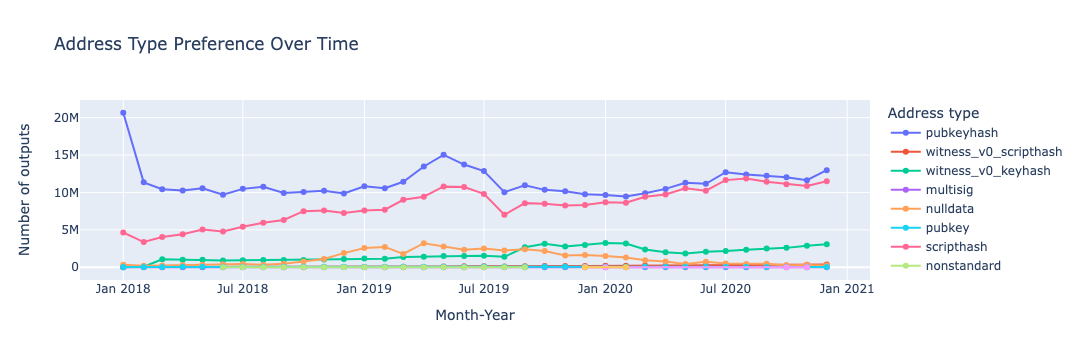

In [41]:
(transactions
 .withColumn("timestamp", F.date_format("block_timestamp", "yyy-MM"))
 .select("timestamp", F.explode("outputs"))
 .select("timestamp", F.col("col.type").alias("Address type"))
 .groupby("timestamp", "Address type")
 .count()
 .withColumnRenamed("timestamp", "Month-Year")
 .withColumnRenamed("count", "Number of outputs")
 .sort("Month-Year")
 .pandas_api()
 .set_index("Month-Year").plot.line
    (title="Address Type Preference Over Time",
    y="Number of outputs",
    color="Address type",
    markers=True))

<center><b>Figure 2.</b> Address Type Preference Over Time</center>

The address type was arrived at by exploding the outputs column and acquiring the nested column `type` from the exploded column.

What is most notable in the figure above is that both pubkeyhash and scripthash are being subscribed to by most users over time. For the network, this means that not much effort is done in order to promote more usage of the better address types such as taproot and scripthash, over the legacy address type which is the pubkeyhash. 

Hence, as a recommendation to the network, more users should be encouraged to adapt to the newer address types as compared to the legacy pubkeyhash type, the scripthash type, on the buyer and seller side, promotes less transaction fees by separating the authentication data from the transaction data and thus, on the miner side, allows miners to fill more blocks than what is normally possible in the pubkeyhash type (Leather, n.d.). On the other hand, the taproot type provides the same functionality as the scripthash type but is subjectively better, as it allows one to create smart contracts (or contracts signed by multiple parties) which are made indistinguishable from normal contracts by the taproot upgrade and which then provide more enhanced user privacy (Leather, n.d.; Trust Machines, n.d.). 

Still, as seen in the figure, there is an increasing trend in the users using the scripthash type, and it can be inferred that the numbers may possibly increase more in the future and be greater than the numbers of the pubkeyhash type line (Refer to Figure 1).

<h3 style="color: #F7931A;">A.2 Version Used Or Subscribed To By The Users Over Time</h3>

There are three blockchain versions. However, in this dataset, there are only two partaining to blockchain 1.0 and 2.0 because blockchain 3.0 is specifically for broader applications, covering industries and sectors outside of the finance and economic domains. In other words, the first two versions are the only ones that apply to cryptocurrency transactions (InterValue, 2018).

Version 1.0 is the foundational blockchain technology created by Satoshi Nakamoto. It represents the simplest form of a digital ledger, enabling secure and permanent recording of transaction data. Additionally, it allows miners—the individuals who add data to the blockchain—to earn rewards. Building on this, version 2.0 enhances the functionalities and processes introduced in the first version, incorporating additional features and capabilities (Kisters, 2022).

One of the key distinctions between Blockchain versions 1 and 2 is the introduction of smart contracts in version 2.0. These contracts are code sets that automatically execute when specific conditions are met, expanding blockchain's utility beyond just transactional capabilities (Kisters, 2022). For instance, in Bitcoin, smart contracts execute transactions when pre-set conditions are fulfilled by users. This feature supports various applications, from cryptocurrency-based games to financial services like lending, by providing a decentralized framework for operations (River, n.d.).

In [42]:
df_version_ot = (transactions
    .withColumn("timestamp", F.date_format("block_timestamp", "yyy-MM"))
    .select(F.col("version").cast("string"), "timestamp")
    .groupby("timestamp", "Version")
    .count()
    .withColumnRenamed("timestamp", "Month-Year")
    .withColumnRenamed("count", "Number of transactions")
    .sort("Month-Year")
    .pandas_api())

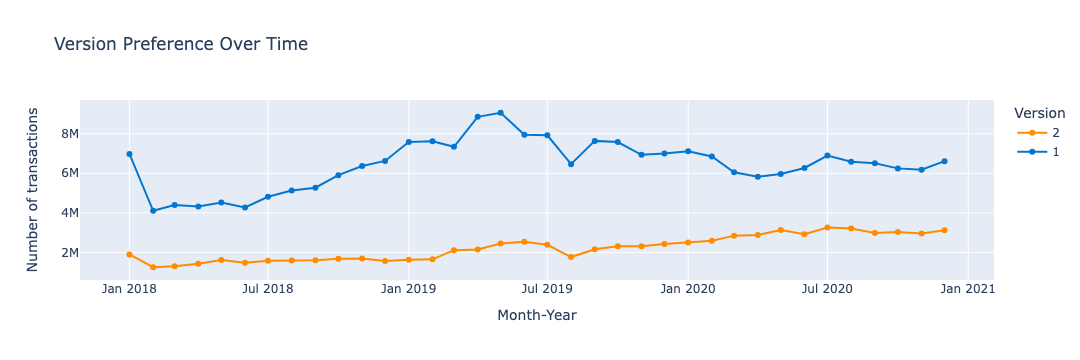

In [43]:
(df_version_ot.set_index("Month-Year").plot.line
    (title="Version Preference Over Time",
    y="Number of transactions",
    color="Version",
    markers=True,
    color_discrete_map={"1": 'rgba(4, 118, 208, 1)',
    "2": 'rgba(255, 140, 0, 1)'}))

<center><b>Figure 3.</b> Version Preference Over Time</center>

While the number of transactions using Version 1.0 blockchain technology shows considerable fluctuation and does not necessarily display a consistent upward trend, Version 2.0 transactions tend to increase steadily over time. Despite this gradual growth in Version 2.0, the overall volume of Bitcoin transactions conducted on the blockchain remains significantly higher with Version 1.0 compared to Version 2.0 (Refer to Figure 2).

This analysis can mean that a significant proportion of Bitcoin users transact on the main functionalities of the blockchain, straight out exchange of Bitcoin between buyers and sellers without any other coded requirements to be met. These transactions can refer to trading activities or commodity exchanges for Bitcoin. An estimate of around 30% of transaction are from version 2, which can mean that smart contracts could be applied. It can be speculated that these transactions may come from decentralized applications that allow transactions to be pushed to the blockchain after user rules are met. An example of this are time locked bitcoin transactions and multi-signature scripts which adds layer of protection for loss of funds. The smart contract can require three signatures before a certain period of time before a transaction is executed (River, n.d.).

<h3 style="color: #F7931A;">A.3 Bitcoin Price Trend Over Time, Coinbase Transactions, and Noncoinbase Transactions</h3>

There are two main types of transactions in blockchain: (1) coinbase transactions and (2) noncoinbase transactions. Coinbase transactions are unique as they do not involve a sender and are used by miners to collect mining rewards and transaction fees. These transactions are responsible for introducing new coins into the system and are a way for miners to earn (Deer, 2023). 

For better understanding, the primary distinction between mining rewards and fees lies in their sources and the rules that govern them. Both serve as compensation for miners for adding transactions to the blockchain, but they operate differently. Mining rewards are a predetermined amount issued by the blockchain itself and are designed to decrease over time. This reduction in mining rewards, known as halving events, is implemented to curb the influx of new Bitcoin into the market and combat inflation. During these events, the rewards are cut in half, subsequently allowing another 210,000 blocks to be mined (Conway, 2024). Mining fees are paid by the sellers initiating Bitcoin transactions—a portion of the transferred Bitcoin value is given to the miner as compensation for validating the transaction on the blockchain (Becker, 2021).

Noncoinbase transactions, on the other hand, involve exchanges between buyers and sellers, transferring cryptocurrency from one address to another. These are the typical transactions that miners validate and include in a block.

In [37]:
btc_value = (
    btc_usd_data.select("Date", "Close")
    .withColumn("close", F.col("Close").cast("float"))
    .withColumn("date", F.col("Date").cast("timestamp"))
    .withColumnRenamed("date", "Date")
    .withColumnRenamed("close", "Close")
    .filter((F.year(F.col("date")) >= 2018) & (F.year(F.col("date")) <= 2020))
    .pandas_api()
)

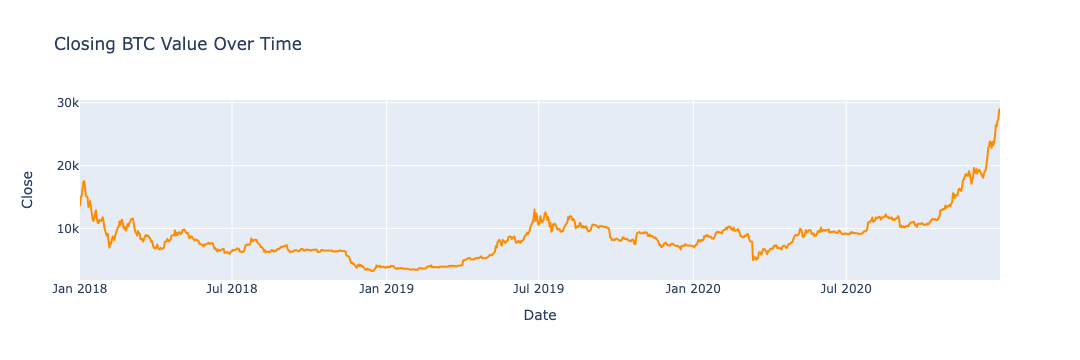

In [38]:
btc_value.plot.line(x="Date", y="Close", title="Closing BTC Value Over Time",
                   color_discrete_sequence=['rgba(255, 140, 0, 1)'])

<center><b>Figure 4.</b> Closing BTC Value Over Time</center>

From 2018 to mid-2020, Bitcoin's price remained relatively stable and low, though it did experience some sudden changes and short-term downtrends before stabilizing. Notably, significant dips occurred around November 2018 and March 2020, potentially due to impactful news or events. The price began to rise noticeably in the fourth quarter of 2020, during the ongoing COVID-19 pandemic. Although this report does not cover data beyond a certain date range, it is relevant to mention that the upward trend continued, with prices consistently exceeding $35,000 by January 2021. This suggests that Bitcoin’s price trend has been following an exponential growth trajectory (Refer to Figure 3).

The notable fall in value at the end of 2018 was linked to the blockchain splits of Bitcoin Cash (BCH) and Bitcoin Satoshi's Vision (BSV). Despite these being separate blockchains with different cryptocurrencies than the original Bitcoin (BTC) blockchain, their splits still influenced Bitcoin's value, leading to a decrease in its price (Rooney, 2018). To provide some context, a split, also known as a hard fork, occurs when a new blockchain is created due to ideological differences. Bitcoin (BTC), the original blockchain developed by Satoshi Nakamoto, initially had a block size limit of 4 MB, which is the maximum amount of data each block can hold. Supporters who advocated for increased scalability created a separate blockchain, Bitcoin Cash (BCH), which initially had a block size limit of 8 MB and was later increased to 32 MB (Reiff, 2024). In late 2018, another split occurred leading to the creation of Bitcoin Satoshi's Vision (BSV), which further expanded the block size limit to 128 MB (Reiff, 2024).

The sharp decline in Bitcoin's value in March 2020 can be attributed to the onset of the COVID-19 pandemic, which brought significant uncertainties to investment markets. This period of instability affected not only Bitcoin but also caused a substantial downturn in the stock market (Royal, 2024).

Given the observed trends and fluctuations in Bitcoin's value, it prompts a question: how do these compare with the actual transaction trends for both coinbase and non-coinbase transactions? Additionally, it is important to consider how the events mentioned earlier correlate with changes in these transaction trends.

In [34]:
df_cb = (
    transactions
    .groupby('date')
    .agg(
        F.sum(F.when(F.col("is_coinbase") 
                     == "true", 1)
              .otherwise(0))
        .alias("coinbase_transactions"),
        F.sum(F.when(F.col("is_coinbase") 
                     == "false", 1)
              .otherwise(0))
        .alias("noncoinbase_transactions")
    ).sort('date')
        .withColumnRenamed("date", "Date")
        .withColumnRenamed("coinbase_transactions", "Coinbase Transactions")
        .withColumnRenamed("noncoinbase_transactions",
                           "Noncoinbase Transactions")
        .pandas_api()
        )

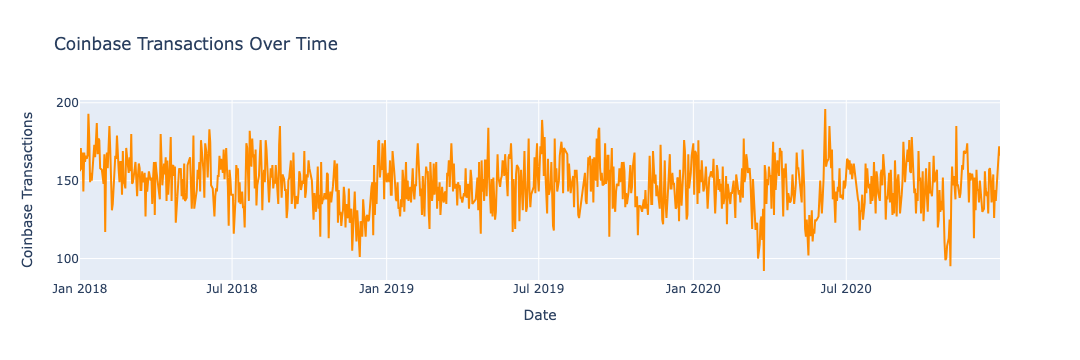

In [35]:
df_cb.plot.line(x="Date", y="Coinbase Transactions",
                title="Coinbase Transactions Over Time",
                color_discrete_sequence=["rgba(255, 140, 0, 1)"])

<center><b>Figure 5.</b> Coinbase Transactions Over Time</center>

For the given figure above, the coinbase transactions were acquired from the transactions table by finding transactions with `is_coinbase` equal to True.

Although the number of transactions tend to fluctuate over time, it still resembles a relatively flat trend overall, without any sign of a linear increase or decrease. It is worth noting, however, that there are sudden dips or troughs seen in the trend. Particularly, they can be observed around November 2018, March 2020, May 2020, and November 2020 (Refer to Figure 4).

It is observed that dips in coinbase transactions often align with decreases in Bitcoin's value, particularly during the sudden declines in November 2018 and March 2020. These price drops were previously attributed to hard forks in the blockchain and the uncertainties introduced by the COVID-19 pandemic. It is reasonable to speculate that a decrease in Bitcoin's price directly impacts transaction volumes by reducing the value of the fees and rewards that miners receive.

The decline observed in May 2020 was due to a halving event, which reduced the fixed mining rewards from 12.5 BTC to 6.25 BTC per block (Conway, 2024). It may be said that such a sudden decrease in rewards prompts miners to modify their setups and operations to adapt to reduced earnings, leading to a temporary drop in mining outputs. This assumption is supported by the fact that after the sharp decline in May 2020, mining activity gradually returned to normal levels.

The dip in November 2020 lacks specific documented causes. It might be assumed that the decrease in transactions was influenced by increased market volatility due to the COVID-19 pandemic. This period could have coincided with a surge in global infection rates, potentially impacting transaction volumes mined onto the blockchain.

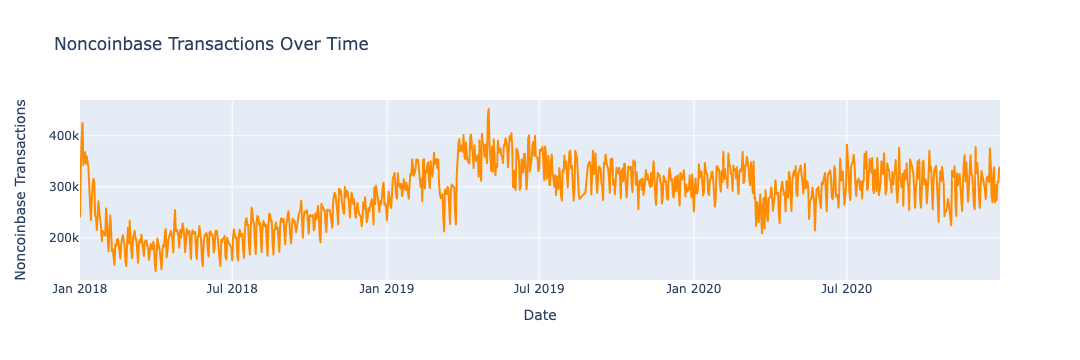

In [36]:
df_cb.plot.line(
    x="Date", y="Noncoinbase Transactions",
    title="Noncoinbase Transactions Over Time",
    color_discrete_sequence=['rgba(255, 140, 0, 1)']
)

<center><b>Figure 5.</b> Noncoinbase Transactions Over Time</center>

For the given figure above, the noncoinbase transactions were acquired from the transactions table by finding transactions with `is_coinbase` equal to False.

The trend in noncoinbase transactions does not follow a consistent linear pattern; instead, it exhibits dips, increases, and fluctuations at different times. Several key periods merit further discussion: the decline in transactions from January to February 2018, in March 2019, in March 2020, and in May 2020, as well as the period of stable transaction volume that coincided with Bitcoin's price increase from October 2020 onwards (Refer to Figure 5).

The decline in transactions in 2018 could be attributed to stricter regulations in the cryptocurrency market, particularly in countries like China and India. China took measures to block all platforms related to the trading and issuance of initial coin offerings (ICOs), while India was actively considering a ban on the use of digital currencies altogether. Additionally, financial institutions such as the Lloyds Banking Group in the United Kingdom implemented bans on using credit cards to purchase cryptocurrencies (Kharpal, 2018).

It is challenging to identify specific reasons for the reduced number of transactions in March 2019, as the transaction volume was consistently low throughout the month. Without more context from external sources or detailed insights from the block and transaction data—which are limited to protect the anonymity of those involved—it is not feasible to speculate on the causes of this decline.

In March 2020, the onset of the COVID-19 pandemic was confirmed. During this time, both the value of Bitcoin, the number of coinbase transactions, and the number of noncoinbase transactions experienced declines. It appears that the uncertainty caused by the pandemic led to a standstill among buyers and sellers, reducing the volume of noncoinbase transactions. This hesitancy likely stemmed from uncertainty over whether to retain or sell Bitcoin, as market participants were unsure about future price movements—whether prices would rebound or continue to decline.

The decrease in noncoinbase transactions during this period might have been influenced by anticipation of the May 2020 halving event. It is assumed that miners were discouraged by the prospect of lower rewards, which restrained their activity in adding new transactions to the blockchain immediately following the halving. With fewer blocks being mined, there was a reduction in recorded transactions. Most likely, these transactions were delayed and subsequently added once the number of coinbase transactions began to recover.

<h3 style="color: #F7931A;">A.3 Average Target and Average Difficulty Over Time</h3>

To guide the discussion of insights, three terms must be clearly defined: hash, target, and difficulty. A hash is a function that converts an input (transaction details and nonce) into an encrypted output (Investopedia, 2023). The resulting hash of any Bitcoin transaction must be less than the target—a specified hash value. The target exists and is updated every 2,016 blocks to ensure that all transactions in the blockchain are unique (Walker, 2024). 

Difficulty, on the other hand, is the value attached to how computationally expensive it is to verify and mine transactions entered onto the blockchain—the higher the value, the more difficult it is (Investopedia, 2021).

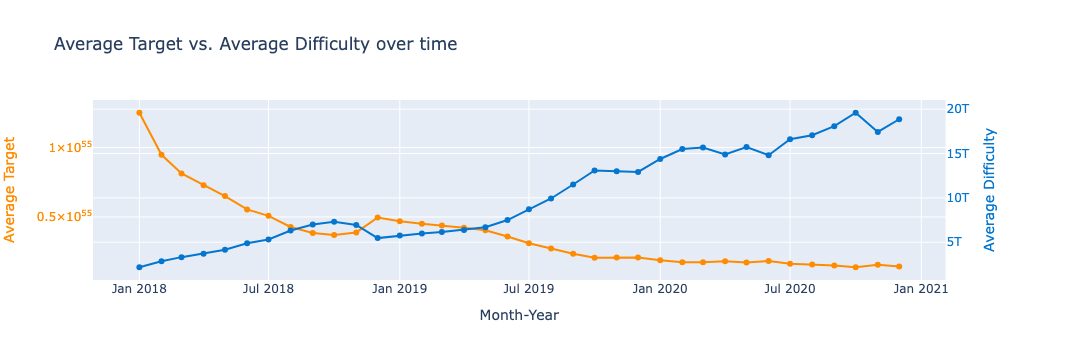

In [21]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    (blocks.select("timestamp", "bits", "difficulty")
       .withColumnRenamed("difficulty", "Difficulty")
       .withColumn("timestamp", F.date_format("timestamp", "yyy-MM"))
       .withColumn("exponent", 
                   F.conv(F.regexp_extract("bits", r"(\d{2}).+", 1),
                          16, 10))
       .withColumn("coef", 
                   F.conv(F.regexp_extract("bits", r"\d{2}(.+)", 1),
                          16, 10))
       .withColumn("Target",
                   F.col("coef") * 2 ** (8 * (F.col("exponent") - 3)))
       .groupby("timestamp")
       .avg("Target", "Difficulty")
       .sort("timestamp")
       .withColumnRenamed("avg(Target)", "Average Target")
       .withColumnRenamed("avg(Difficulty)", "Average Difficulty")
       .withColumnRenamed("timestamp", "Month-Year")
       .withColumn("Name", F.lit("Average Target"))
       .pandas_api()
       .set_index("Month-Year")
       .plot.line(y="Average Target",
                  title="Average Target",
                  color="Name",
                 color_discrete_sequence=["rgba(255, 140, 0, 1)"],
                 markers=True)).data[0],
        secondary_y=False)

fig.add_trace(
    (blocks.select("timestamp", "bits", "difficulty")
       .withColumnRenamed("difficulty", "Difficulty")
       .withColumn("timestamp", F.date_format("timestamp", "yyy-MM"))
       .withColumn("exponent", 
                   F.conv(F.regexp_extract("bits", r"(\d{2}).+", 1),
                          16, 10))
       .withColumn("coef", 
                   F.conv(F.regexp_extract("bits", r"\d{2}(.+)", 1),
                          16, 10))
       .withColumn("Target",
                   F.col("coef") * 2 ** (8 * (F.col("exponent") - 3)))
       .groupby("timestamp")
       .avg("Target", "Difficulty")
       .sort("timestamp")
       .withColumnRenamed("avg(Target)", "Average Target")
       .withColumnRenamed("avg(Difficulty)", "Average Difficulty")
       .withColumnRenamed("timestamp", "Month-Year")
       .withColumn("Name", F.lit("Average Difficulty"))
       .pandas_api()
       .set_index("Month-Year")
       .plot.line(y="Average Difficulty",
                 markers=True, 
                  title="Average Difficulty",
                  color="Name",
                 color_discrete_sequence=["rgba(4, 118, 208, 1)"]
                 )).data[0],
                 secondary_y=True)

fig.update_layout(
    title_text="Average Target vs. Average Difficulty over time",
    showlegend=False
)


fig.update_xaxes(title_text="Month-Year")


fig.update_yaxes(title_text="Average Target", secondary_y=False,
                titlefont=dict(color="rgba(255, 140, 0, 1)"),
                 tickfont=dict(color="rgba(255, 140, 0, 1)"))
fig.update_yaxes(title_text="Average Difficulty", secondary_y=True,
                titlefont=dict(color="rgba(4, 118, 208, 1)"),
                 tickfont=dict(color="rgba(4, 118, 208, 1)"),
                 anchor="x",
                 overlaying="y",
                 side="right")

fig.show()

<center><b>Figure 6.</b> Average Target vs. Average Difficulty Over Time</center>

In the figure above, the target value is engineered from the bits by applying the formula: $coefficient * 2 ^ (8 * (index — 3))$ (Sohn, 2019) where index is the first two digits of the bits and coefficient is the next six digits after the index. Both are in hexadecimal and are first converted into decimal before operations are done on them. 

The chart illustrates an inverse correlation between the blockchain's target and the average mining difficulty. As the blockchain accumulates more unique hashes, fewer output values from the hash function can meet the designated target. Consequently, more attempts may be required by the hash function to process a transaction into the blockchain, leading to an increase in difficulty over time (Refer to Figure 6). 

For miners, this trend suggests potential increases in capital expenditures, as the escalating difficulty could necessitate more advanced and expensive mining equipment. This raises questions about the long-term viability of mining operations, particularly as the available output values from hash functions diminish.

The discussion around average target versus average difficulty primarily concerns miners, providing a natural transition to a deeper examination of coinbase transactions and their implications for miners. The following section will explore this topic in more detail.

<h2 style="color: #F7931A;">B. Miners</h2>

Examining miners more closely, the analysis begins with block complexity, which includes identifying the factors that determine the difficulty of mining operations. Next, the investigation shifts to understanding what influences mining rewards. Following this, the team looks at trends in 24-hour locktime to pinpoint the best times for mining—specifically, when the most transactions are available to be added to the blockchain. Finally, the analysis covers mining rewards over time, emphasizing how these incentives are structured.

<h3 style="color: #F7931A;">B.1 Block Complexity</h3>

Block complexity is closely related to the memory intensity involved in mining transactions into the blockchain. The team identified four different factors that might affect mining difficulty. It was determined that hash targets are a factor, but other elements such as the number of transactions in a block, the chainwork, and the output value may also play roles.

<h4 style="color: #F7931A;">B.1.1 Difficulty vs. Number of Transactions</h4>

A block is a structure that contains multiple transactions which have been validated by miners and are poised to be added to the blockchain. The number of transactions in a block is directly influenced by the block size or data capacity limits set by the blockchain's original creators, and therefore, can vary from one block to another (Crooks, 2023). Transactions, according to Bitcoin.com, are messages that state the transfer of Bitcoin from senders to receivers. The visualation below looks at how the amount of these transactions relate to mining difficulty.

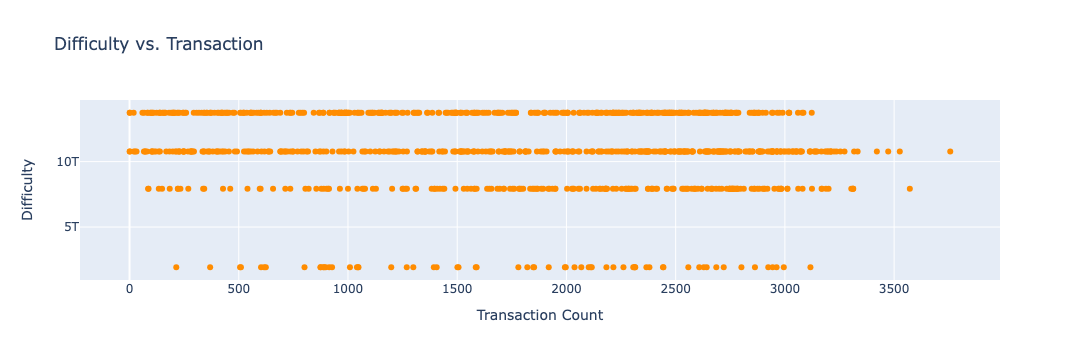

In [46]:
(
    blocks.select("difficulty", "transaction_count")
    .withColumnRenamed("difficulty", "Difficulty")
    .withColumnRenamed("transaction_count", "Transaction Count")
    .pandas_api()
    .plot.scatter(
        x="Transaction Count", y="Difficulty",
        title="Difficulty vs. Transaction",
        color_discrete_sequence=['rgba(255, 140, 0, 1)']
    )
)

<center><b>Figure 7.</b> Difficulty vs. Number of Transactions</center>

As observed above, there appears to be no correlation between the number of transactions and the intensity of mining operations. Despite an increase in the count of transactions per block, all levels of mining difficulty are encountered (Refer to Figure 7). 

A possible reason for the lack of correlation observed could be that mining difficulty is more closely related to hashes, which are computed at the block level, rather than to the number of transactions. Hashes, unique codes representing data, are generated each time a block is added to the blockchain. These hashes are produced by a hash function that repeatedly generates or guesses unique codes during its operation (Scaling Parrots, n.d.).

ExplainCKBot indicates that difficulty is adjusted every 2,016 blocks based on the network's hash rate. The hash rate refers to the total number of calculations or guesses made by the entire network. A higher hash rate implies a greater number of miners, which theoretically increases the number of blocks that can be added to the blockchain. When this happens, the Bitcoin blockchain increases the difficulty level to regulate the number of blocks entering. This supports the idea that the number of miners, computing the hashes, plays a more critical role in determining mining difficulty than the number of transactions (2023). 

<h4 style="color: #F7931A;">B.1.2 Difficulty vs. Chainwork</h4>

To further back the idea that hashes play a role in difficulty, it is critical to explore the concept of the chainwork. Chainwork is the number of hash attempts expected to build the whole blockchain. This may be thought of as the cummulative number of guesses or hash attempts to achieve the addition of all blocks in the blockchain (Walker, 2024). Let us observe what the visualization below suggests.

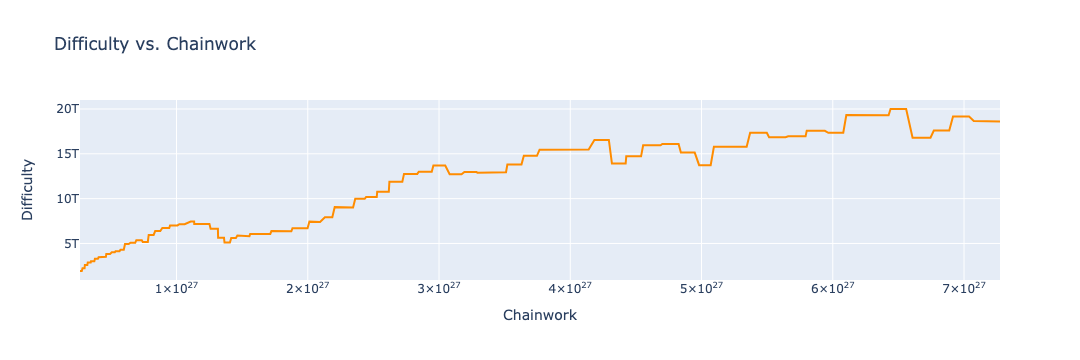

In [40]:
(
    blocks.select("chainwork", "difficulty")
    .withColumn("chainwork",
                htd_udf(F.col("chainwork")).cast(DecimalType(38, 0)))
    .sort(F.col("chainwork"))
    .withColumnRenamed("chainwork", "Chainwork")
    .withColumnRenamed("difficulty", "Difficulty")
    .pandas_api()
    .plot.line(x="Chainwork", y="Difficulty",
               title="Difficulty vs. Chainwork",
              color_discrete_sequence=['rgba(255, 140, 0, 1)'])
)

<center><b>Figure 8.</b> Difficulty vs. Number of Chainwork</center>

In order to make the chainwork more understandable, it is converted from hexadecimal to decimal using a user-defined function, and it is casted to a DecimalType with a precision of 38 (with a maximum value of 38) to accomodate all of the digits from the chainwork and with a scale of 0, as to accomodate only the whole numbers of the decimal-converted chainwork, which would be enough for a simple comparison across difficulties.

As chainwork values increase, there is typically a corresponding rise in mining difficulty, indicating that chainwork could be a useful metric for gauging the growth of mining activity over time. With both chainwork and difficulty increasing simultaneously, it is likely that more miners are entering the network, contributing to higher hash rates (Refer to Figure 8).

<h4 style="color: #F7931A;">B.1.3 Difficulty vs. Amount Transferred</h4>

The team also checks whether the amount being transferred to the receiver contributes to the increase in difficulty. 

In [221]:
output_df = (
    transactions.select("outputs", "output_value",
                        "is_coinbase", "block_number", "hash")
    .filter((F.col("is_coinbase") == "false") &
           (F.size(F.col("outputs")) == 1))
    .groupby("block_number")
    .sum("output_value")
    .select(
        F.col(
            "sum(output_value)").alias(
            "Transaction_Values"), "block_number")
            )

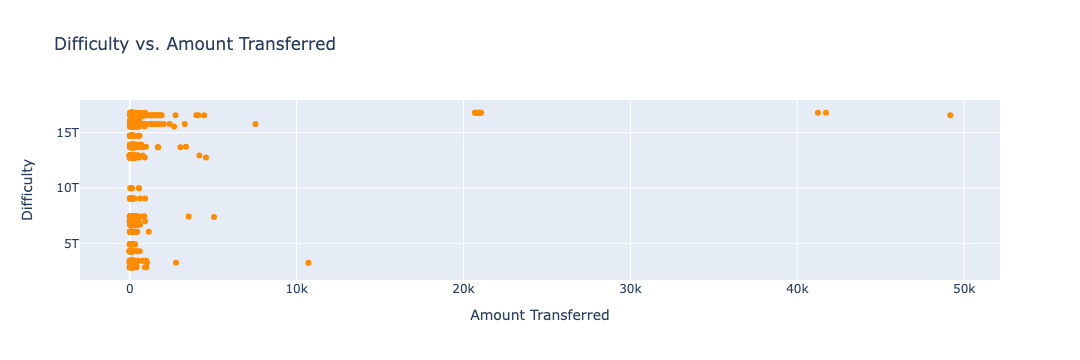

In [222]:
(
    blocks.join(output_df, blocks.number == output_df.block_number, "inner")
    .select("difficulty", "Transaction_Values")
    .filter(F.col("Transaction_Values") < 50_000)
    .withColumnRenamed("Transaction_Values", "Amount Transferred")
    .withColumnRenamed("difficulty", "Difficulty")
    .pandas_api()
    .plot.scatter(
        x="Amount Transferred",
        y="Difficulty",
        title="Difficulty vs. Amount Transferred",
        color_discrete_sequence=['rgba(255, 140, 0, 1)']
    )
)

<center><b>Figure 9.</b> Difficulty vs. Amount Transferred</center>

Given that noncoinbase transactions may have at most two outputs, one for change and one for the payment, only the output values of noncoinbase transactions with one output are considered as to avoid including the change in the analysis and visualization and as to acquire only the amount being transferred. These are then aggregated by block number and summed as to get the total amount being transferred per block.

The scatterplot in Figure 9 demonstrates no apparent relationship, as the difficulty differs greatly for a small interval of amount transferred (as seen in the amount transferred near 0). Moreover, even if the amount transferred increases, there is no consistent increase (nor decrease) as seen at the amount transferred near 10k where one has a difficulty of 15T and the other has a difficulty of less than 5T. Lastly, it could be observed (from hovering at points near the ends of the graph) that an amount transferred of 18 has roughly the same difficulty as an amount transferred of 41k, which further supports that there is no relationship between the two variables.

Given all these, these could be because the amount transferred likely has minimal or no influence on the computation of hashes. Consequently, it generally does not impact the number of iterations required to achieve the target value (Refer to Figure 9).

<h4 style="color: #F7931A;">B.1.4 Difficulty vs. Target</h4>

From a prior visualization, it was shown that mining targets and difficulty share an inverse relationship; as targets decrease, difficulty increases over time. This trend was initially attributed to the reduction in available hash values that the function can utilize to add a block to the blockchain. Let us now explore a different visualization to see what further insights we can gather.

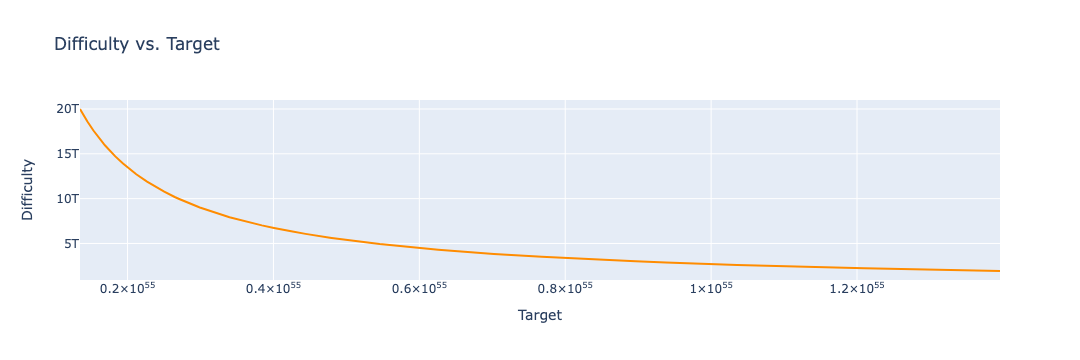

In [43]:
(
    blocks.select("bits", "difficulty")
    .withColumnRenamed("difficulty", "Difficulty")
    .withColumn("exponent", F.conv(F.regexp_extract("bits",
                                                    r"(\d{2}).+", 1), 16, 10))
    .withColumn("coef", F.conv(F.regexp_extract("bits",
                                                r"\d{2}(.+)", 1), 16, 10))
    .withColumn("Target", F.col("coef") * 2 ** (8 * (F.col("exponent") - 3)))
    .sort(F.col("Target"))
    .pandas_api()
    .plot.line(x="Target", y="Difficulty", title="Difficulty vs. Target",
              color_discrete_sequence=['rgba(255, 140, 0, 1)'])
)

<center><b>Figure 10.</b> Difficulty vs. Target</center>

Figure 10 indicates that lower target values correspond to higher difficulty. This relationship is logical because lower hash targets reduce the number of valid hashes that can be generated, necessitating more iterations to find a suitable hash. As the required iterations increase, so do the hash rates. As previously noted, higher hash rates prompt the system to increase the mining difficulty.

<h3 style="color: #F7931A;">B.2 Block Weight, Transaction Count, & Coinbase Transaction Value Relationship</h2>

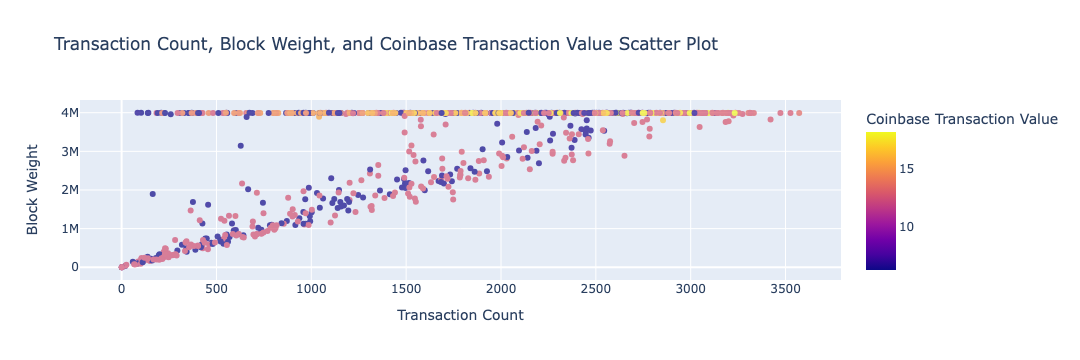

In [223]:
(
    transactions.select("output_value", "is_coinbase", "block_number")
    .filter(F.col("is_coinbase") == "true")
    .join(
        blocks.select("number", "weight", "transaction_count",
                     "date"),
        transactions.block_number == blocks.number,
    )
    .withColumnRenamed("transaction_count", "Transaction Count")
    .withColumnRenamed("weight", "Block Weight")
    .withColumnRenamed("output_value", "Coinbase Transaction Value")
    .withColumnRenamed("date", "Timestamp")
    .pandas_api()
    .plot.scatter(x="Transaction Count", y="Block Weight",
                  hover_data=["Transaction Count",
                              "Block Weight",
                              "Coinbase Transaction Value",
                              "Timestamp"],
                  color="Coinbase Transaction Value",
                  title="Transaction Count, "
                  "Block Weight, and Coinbase Transaction Value Scatter Plot")
    .update_traces(opacity=0.7)
)

<center><b>Figure 11.</b> Transaction Count vs. Block Weight Scatter Plot <i>(colored by Coinbase Transaction Value)</i></center>

The figures for coinbase transaction value was engineered by acquiring all transactions which are coinbase and acquiring their total output value (equal to their fixed mining reward and variable transaction fee) (Kamsky, 2023).

As seen in Figure 9, while lower coinbase transaction value is mostly expected for blocks with block weights less than 4 megabytes, once the blocks reach 4 megabytes, it can be seen that the coinbase transaction value for most of the blocks are at the highest value, as indicated by the yellow to orange color in the color bar at the left. Moreover, while there is a linear trend between transaction count and block weight, it is cancelled by the fact that there is a horizontal line at block weight equal to 4 megabytes, indicating that lower transaction counts do not necessarily correlate to lower block weights, and vice-versa.

Given that the coinbase transactions from which the mining reward is derived contains outputs which are both the fixed mining reward and the variable transaction fees (Kamsky, 2023), it can be said from the figure above that miners are incentivized more to fill up the block as much as possible, to maximize the transaction fees in filling one block. Moreover, regardless of the halving (which started at May 2020 or 05-2020), it can be seen across all years that maximizing the block weight leads to more coinbase transaction value (even if the mining reward is decreased overall).

<h3 style="color: #F7931A;">B.3 Total Amount Transferred (in a block) & Coinbase Transaction Value Relationship</h2>

In [231]:
df_noncb = (transactions.select("outputs", "is_coinbase", "block_number",
                               "block_timestamp", "hash", "output_value")
             .filter((F.col("is_coinbase") == "false") &
                    (F.size(F.col("outputs")) == 1))
             .groupby("block_number")
             .agg(F.sum("output_value"))
             .select(
                 F.col(
                     "sum(output_value)").alias(
                     "Total Amount Transferred"),
                     "block_number"))

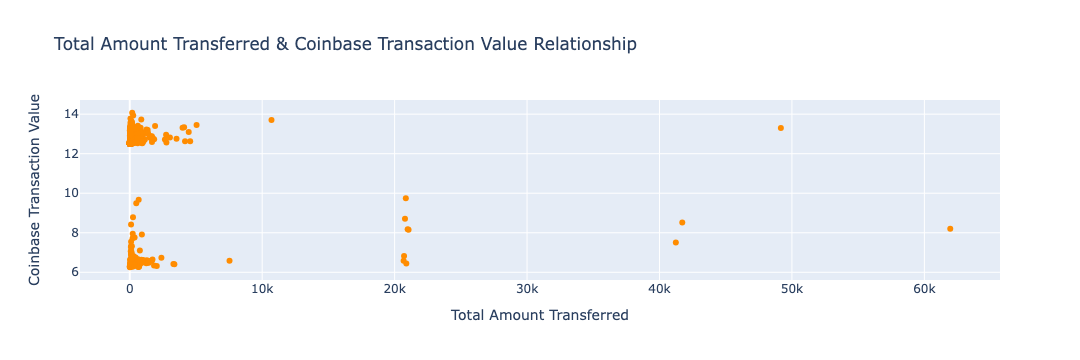

In [232]:
(
    transactions.select("output_value", "is_coinbase", "block_number",
                       "block_timestamp")
    .filter(F.col("is_coinbase") == "true")
    .join(df_noncb, transactions.block_number == df_noncb.block_number)
    .select("output_value",
            "Total Amount Transferred",
            "block_timestamp")
    .withColumn("timestamp",
                         F.date_format("block_timestamp", "yyy-MM"))
    .withColumnRenamed("output_value", "Coinbase Transaction Value")
    .withColumnRenamed("timestamp", "Timestamp")
    .pandas_api()
    .plot.scatter(
        x="Total Amount Transferred",
        y="Coinbase Transaction Value",
        hover_data=["Total Amount Transferred",
                    "Coinbase Transaction Value",
                    "Timestamp"],
        title="Total Amount Transferred"
        " & Coinbase Transaction Value Relationship",
        color_discrete_sequence=['rgba(255, 140, 0, 1)']
    )
)

<center><b>Figure 12.</b> Total Amount Transferred (in a block) & Coinbase Transaction Value Relationship</i></center>

As seen in the figure above, there is no direct relationship between the overall noncoinbase transaction value and the coinbase transaction value (both the mining reward and mining fees), regardless of whether the halving occurred or not (as assessed by hovering over some of the points in each "cluster"). This is corroborated by Saylor Academy (n.d.) which stated that transaction value does not affect the transaction fee (a variable component of the coinbase transaction value) directly.

<h3 style="color: #F7931A;">B.4 24-Hour Lock Time Trend</h2>

In [46]:
union_bt = (transactions
 .select(['lock_time', 'is_coinbase'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time < 500000000)
        )
 .join(blocks.select("number", "timestamp"), 
       transactions.lock_time == blocks.number)
 .select(F.hour(F.col("timestamp")).alias("lock_hour"), "is_coinbase"))

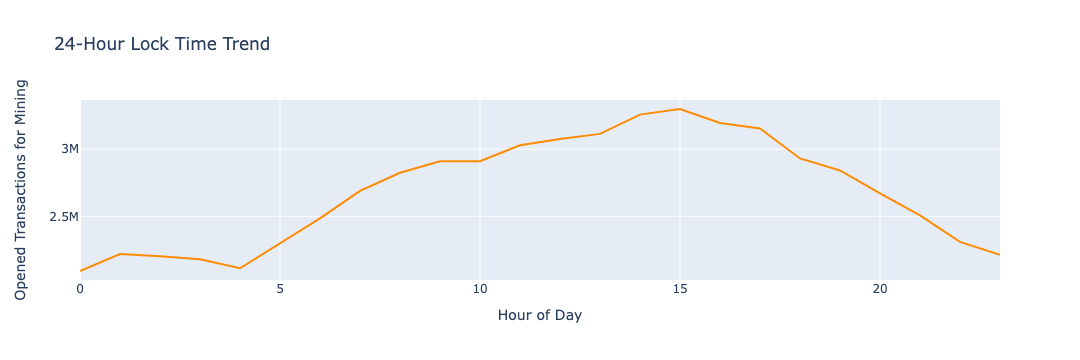

In [47]:
spark.conf.set("spark.sql.session.timeZone", "UTC")
(transactions
 .select(['lock_time', 'is_coinbase'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time >= 500000000)
        )
 .withColumn("lock_hour", F.hour(F.from_unixtime(F.col("lock_time"))))
 .select("lock_hour", "is_coinbase")
 .union(union_bt)
 .groupby("lock_hour")
 .count()
 .sort("lock_hour")
 .withColumnRenamed("lock_hour", "Hour of Day")
 .withColumnRenamed("count", "Opened Transactions for Mining")
 .pandas_api()
 .set_index("Hour of Day").plot.line(y="Opened Transactions for Mining",
                                  title="24-Hour Lock Time Trend",
                            color_discrete_sequence=['rgba(255, 140, 0, 1)']))

<center><b>Figure 13.</b> 24-Hour Lock Time Trend</i></center>

In deriving the hour of the day given a locktime, there are two things to consider: first, if the locktime is below 500 million, it means that the transaction would open only once the n-locktimeth block is reached, and second, if the locktime is equal to or greater than 500 million, it is interpreted as a Unix Epoch timestamp (seconds since Jan-1-1970) (Saylor Academy, n.d.). 

Given this, for transactions with locktime less than 500 million, in order to acquire their approximate locktime in time format, the lock time (in block height) is mapped to the block with block number equal to the locktime, using the block timestamp as the locktime of the transaction in time format. 

For transactions with locktime equal to or greater than 500 milion, the locktime is only converted from Unix Epoch timestamp to the standard timestamp (in UTC which was used in accordance with what was stated by CoinMarketCap (n.d.)).
    
As seen above in the figure, miners can be advised to mine in the early afternoon (13:00 - 16:00) as these are the times when most of the transactions' locktime elapse, and so, there may be more transactions to choose from when filling a block. This may seem as erring more on the cost-side of a cost-benefit analysis as these hours may be within the peak hours of electricity usage, where mining in these hours may cost miners a lot as in the case of Time-of-Use or TOU electricity plans and prevent them from making a profit from mining (Pellini, 2022; Thoubboron, 2024). However, for miners whose electricity peak hours may be in the early to late morning or who may be subscribing to a standard electricity plan, it would be better to follow the advice of mining in the early afternoon as this maximizes the number of transactions to choose from when mining.

In [48]:
spark.conf.unset("spark.sql.session.timeZone")

<h3 style="color: #F7931A;">B.5 Coinbase Transaction Value Trend Over Time</h2>

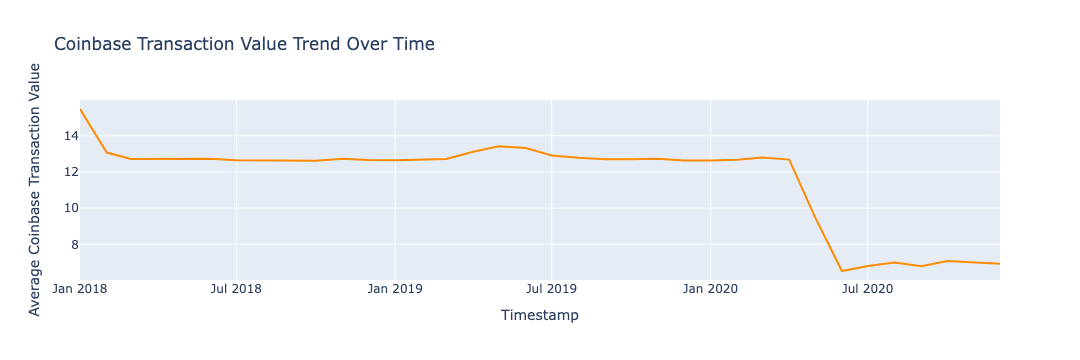

In [214]:
(transactions
    .withColumn("timestamp", F.date_format("block_timestamp", "yyy-MM"))
    .filter(F.col("is_coinbase") == "true")
    .groupby("timestamp")
    .avg("output_value")
    .sort("timestamp")
    .withColumnRenamed("timestamp", "Timestamp")
    .withColumnRenamed("avg(output_value)",
                       "Average Coinbase Transaction Value")
    .pandas_api()
    .set_index("Timestamp")
    .plot.line(y="Average Coinbase Transaction Value",
              title="Coinbase Transaction Value Trend Over Time",
              color_discrete_sequence=['rgba(255, 140, 0, 1)']))

<center><b>Figure 14.</b> Coinbase Transaction Value Trend Over Time</center>

This figure coincides with what was stated in ZeroCap (2024)'s article, which stated that the mining rewards from Bitcoin halved at May 11, 2020 which can be approximately seen in the figure at around May 1, 2020 to June 1, 2020 where the coinbase transaction value (which contains both mining rewards and mining fees) ultimately halved from around 12 to around 6 Bitcoins. The probably reason why the figures at May 1, 2020 point to the average coinbase transaction value as being around 9 is due to the fact that parts of May have the mining reward set at around 12 while other parts have the mining reward set at around 6, causing the average to be around 9. Given that halving occurs roughly every four years (Reuters, 2024), this may disincentivize future miners from mining and may signal current mining companies to either evaluate whether mining is still profitable regardless of the lower rewards, given their scale.

<h2 style="color: #F7931A;">C. Buyers & Sellers</h2>

Given that the various factors and incentives which affect miners' choices were discussed, points of interests for buyers and sellers which are essentially also influenced by miners' decisions—if they can either have a lesser lead time, or lessen their lead time through higher input values when creating time-locked transactions—would be discussed in this section.

<h3 style="color: #F7931A;">C.1 Median Lead Time Over Time</h3>

In [89]:
union_one = (transactions
 .select(['lock_time', 'is_coinbase', 'output_value', 'block_number'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time < 500000000)
        )
 .join(blocks.select("number", "timestamp"), 
       transactions.lock_time == blocks.number)
 .select(
     (F.col("timestamp")).cast("long").alias("locktime"), "output_value",
     "block_number"))

In [90]:
spark.conf.set("spark.sql.session.timeZone", "UTC")
union_two = (transactions
 .select(['lock_time', 'is_coinbase', 'output_value', 'block_number'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time >= 500000000)
        )
 .withColumn("locktime", (F.col("lock_time").cast("long")))
 .select("locktime", "output_value", "block_number")
 .union(union_one))

In [91]:
union_three = (union_two.join(blocks.select("number", "timestamp"),
       union_two.block_number == blocks.number))

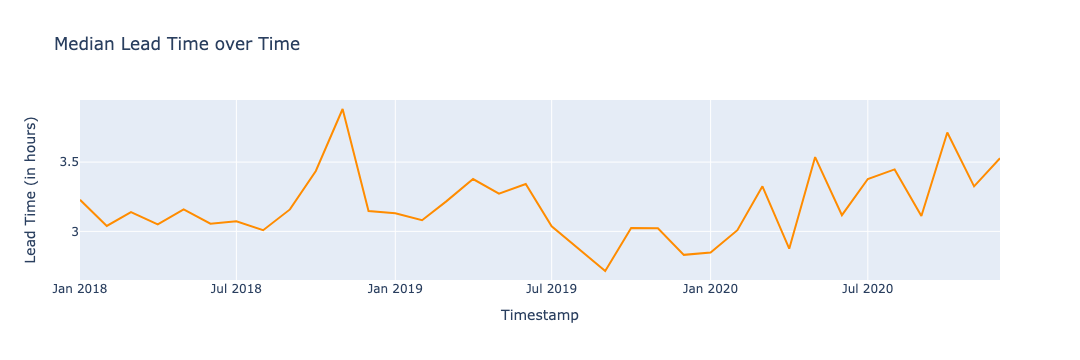

In [92]:
(union_three.withColumn("Lead Time", 
             (F.col("timestamp").cast("long")
             - F.col("locktime")) / 360)
 .withColumn("Timestamp", F.date_format("timestamp", "yyy-MM"))
 .groupby("Timestamp")
 .agg(F.median("Lead Time"))
 .sort("Timestamp")
 .withColumnRenamed("median(Lead Time)", "Lead Time (in hours)")
 .pandas_api()
 .set_index("Timestamp")
 .plot.line(y="Lead Time (in hours)",
            title="Median Lead Time over Time",
           color_discrete_sequence=['rgba(255, 140, 0, 1)']))

<center><b>Figure 15.</b> Median Lead Time Over Time</center>

First, in the figure above, the lead time is acquired by first getting the locktime of a transaction in time format (which was explained beforehand) and acquiring the difference of this and the timestamp of the transaction (in seconds or Unix Epoch timestamp). The leadtime which is in seconds is then converted into hours by dividing it by 360.

In order to account for outlier lock times which may be trivial (given that they may be set at essentially the first block which is essentially zero lock time and other similar logic), the median of the lead time, which is mining time minus lock time, is used. As seen in the figure above, there is a peak in the lead time of the transactions at around November 2018, which can be attributed to Figure 16 which shows the dip in the coinbase transactions or mining, which could be attributed again to the blockchain split at the same time (Rooney, 2018) which caused a dip in the price of Bitcoin (due to the blockchain split-induced uncertainty of the Bitcoin investment market) as seen in Figure 17.

This implies that for sellers and buyers, the Bitcoin price and the events affecting its price influences whether one's transactions, especially one's time-locked transactions, would immediately be mined and validated. Hence, for buyers and sellers, this would mean that transactions should mostly be done during the times that Bitcoin prices are high and stable, as one's intuition would advise, in order to ensure that one's transactions would push through immediately. 

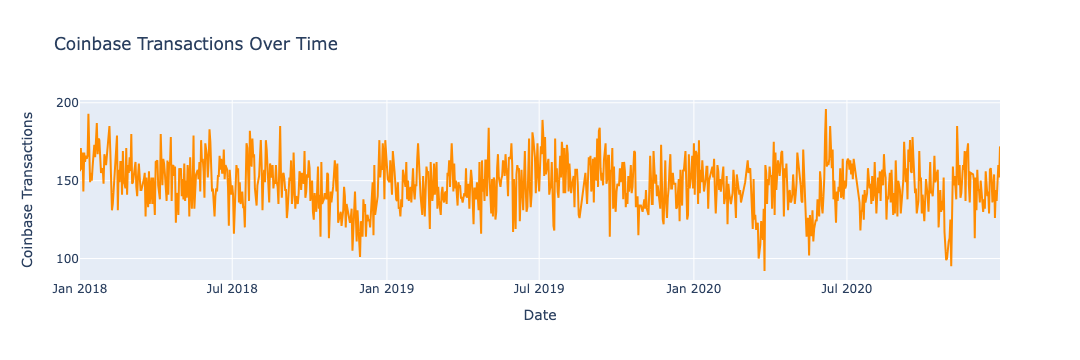

In [153]:
df_cb.plot.line(x="Date", y="Coinbase Transactions",
                title="Coinbase Transactions Over Time",
                color_discrete_sequence=["rgba(255, 140, 0, 1)"])

<center><b>Figure 16.</b> Coinbase Transactions Over Time</center>

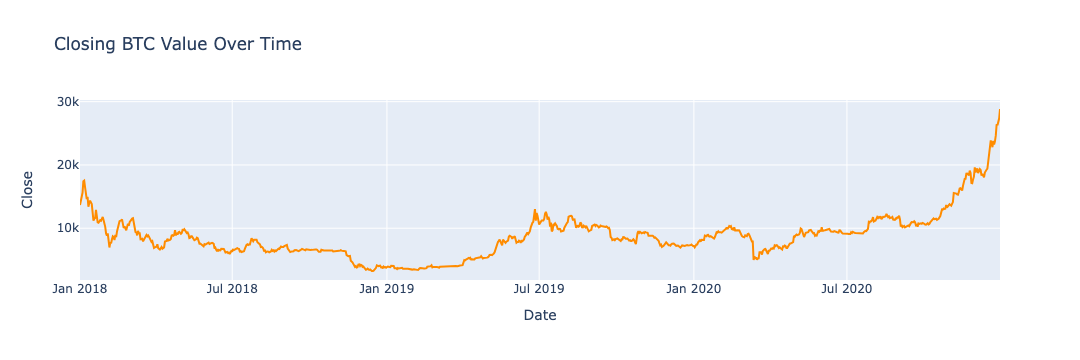

In [152]:
btc_value.plot.line(x="Date", y="Close", title="Closing BTC Value Over Time",
                   color_discrete_sequence=['rgba(255, 140, 0, 1)'])

<center><b>Figure 17.</b> Closing BTC Value Over Time</center>

In [54]:
spark.conf.unset("spark.sql.session.timeZone")

<h3 style="color: #F7931A;">C.2 Total Input Value for Noncoinbase Transactions vs. Lead Time</h3>

In [206]:
union_one = (transactions
 .select(['lock_time', 'is_coinbase', 'block_number', 'hash', 'output_value'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time < 500000000))
 .withColumnRenamed("first(lock_time)", "lock_time"))

In [207]:
union_one_two = union_one.join(
    blocks.select(
        "number", "timestamp"), union_one.lock_time == blocks.number
).select(
    (F.col("timestamp")).cast("long").alias(
        "locktime"), "output_value", "block_number"
)

In [208]:
spark.conf.set("spark.sql.session.timeZone", "UTC")
union_two = (transactions
 .select(['lock_time', 'is_coinbase', 'block_number', 'hash', 'output_value'])
 .filter((
     transactions.is_coinbase == 'false')
         & (transactions.lock_time >= 500000000))
 .withColumn("locktime", (F.col("lock_time").cast("long")))
 .select("locktime", "output_value", "block_number")
 .union(union_one_two))

In [209]:
btc_data = (btc_usd_data
             .select('Date', 'Close')
             .withColumn('close', F.col('Close').cast('float'))
             .withColumn('date', F.col('Date').cast('timestamp'))
             .filter((F.year(F.col('date')) >= 2018) 
                     & (F.year(F.col('date')) <= 2020)))

In [210]:
union_three = (union_two.join(blocks.select("number", "timestamp"),
       union_two.block_number == blocks.number))

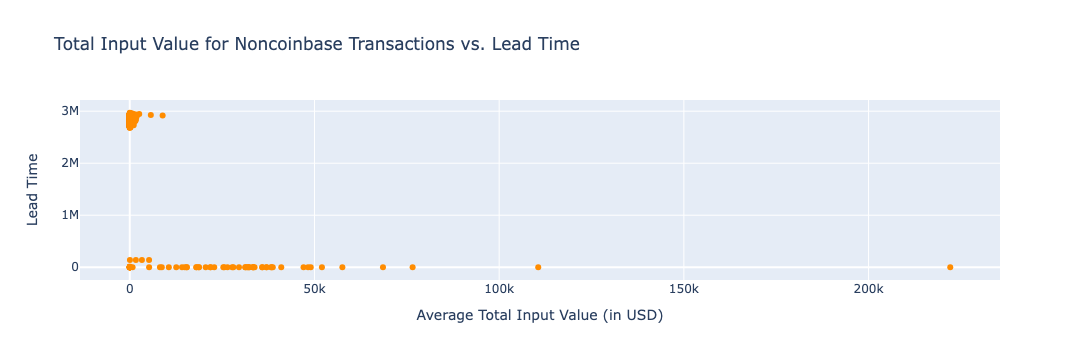

In [213]:
(union_three.join(btc_data, F.date_format(btc_data.date, "MM/dd/yyy") ==
       F.date_format(union_three.timestamp, "MM/dd/yyy"))
 .withColumn("leadtime", 
             (F.col("timestamp").cast("long")
             - F.col("locktime")) / 360)
 .withColumn("Input Value (in USD)",
             F.col("output_value") * F.col("close"))
 .groupby("leadtime")
 .avg("Input Value (in USD)")
 .withColumnRenamed("avg(Input Value (in USD))",
             "Average Total Input Value (in USD)")
 .withColumnRenamed("leadtime", "Lead Time")
 .pandas_api()
 .plot.scatter(x="Average Total Input Value (in USD)",
               y="Lead Time",
        title="Total Input Value for Noncoinbase Transactions vs. Lead Time",
              color_discrete_sequence=['rgba(255, 140, 0, 1)'])
)

<center><b>Figure 18.</b> Total Input Value for Noncoinbase Transactions vs. Lead Time</i></center>

First, given that the total input value (or the total amount sent by the sender regardless of actual amount they want to send) is not in the schema of the transactions table, what served as the substitute or proxy for the total input value would be the overall output value or the payment output plus the change output, which would equate essentially to the overall input that the sender sent. Given this, the input value in USD is acquired by joining the Bitcoin USD table and the table by the date of the block and the date of the closing price and multiplying the total input value of the noncoinbase transactions with its corresponding closing price (in USD). Lastly, the total input value is then grouped and averaged by lead time, as to find what total input value, on average, correspond to a given lead time.

From the figure above, it can be said that there is a point in the total input value in which the lead time for noncoinbase transactions is not both near zero or near the maximum which is 3 million hours. Starting at transactions involving ten thousands of dollars, it can be said that there is almost a certainty that the transaction would immediately be mined as compared to transactions involving only thousand dollars to a few dollars, given that the former only corresponds to a lead time around zero as compared to the latter which may either have a lead time of around zero or three million. 

The lesser lead time associated with higher input values may be attributed to the increase in automatically computed transaction fees as despite transaction values (or input values) not having an effect on these transaction fees, the highly probable increase in number of inputs required to sum up to the overall transaction value (or overall input value) causes also an increase in these transaction fees due to the increase in size it entails (Reed, 2024). This then incentivizes miners to mine the given transaction with the high transaction fee.

In [61]:
spark.conf.unset("spark.sql.session.timeZone")

<a id='Header2'></a>
<img src="images/results_bc.png">

<h2 style="color: #F7931A;">Network</h2>

<b>Address Types.</b> It appears that the network continues to use legacy address types, demonstrating a reluctance to transition to more advanced options. Online resources advocate for the adoption of newer address types because they offer greater flexibility, enhanced privacy with smart contracts, and can reduce transaction fees for those sending or selling Bitcoin. 

<b>Versions.</b> Most transactions within the network utilize blockchain 1.0 rather than blockchain 2.0. This indicates that users primarily engage in standard cryptocurrency exchanges within the Bitcoin ecosystem, as opposed to engaging in activities that require additional functionalities like smart contracts and crypto games. Consequently, in relation to the previous topic, taproot address types are less prevalent since only a small fraction of transactions involve blockchain 2.0. However, it is important to note that the adoption of blockchain 2.0 is gradually rising, suggesting that users may need to reconsider and possibly transition to these newer technologies. 

<b>Events and News.</b> There are abrupt fluctuations in block and transaction volume and price over time, driven by a mix of global and crypto-specific events. Global events refer to occurrences with international repercussions, like the COVID pandemic. Crypto-specific events, on the other hand, are incidents that directly impact the network, such as halving events or hard forks. Regardless of the type of event, users should remain vigilant and prepared to adapt to these sudden shifts, which could have adverse effects. 

<b>Future of Mining.</b> The trends in targets and difficulty over time clearly have implications for miners. As time progresses, the number of valid targets that hash functions can successfully hit diminishes, making mining increasingly challenging. This requires more iterations and, consequently, more powerful mining rigs. Miners need to consider the long-term costs involved and assess whether mining will remain profitable in the future. 

<h2 style="color: #F7931A;">Miners</h2>

<b>Block Complexity.</b> Ultimately, hash rates, influenced primarily by the number of miners in the network, dictate mining difficulty. The visualization comparing difficulty with chainwork illustrates that mining is increasingly becoming saturated over time and requires more substantial computational resources. This raises a crucial question for potential miners contemplating entering the industry: Is it still sensible to invest in mining operations considering the significant investment required to meet the current mining difficulty? 

<b>Block Weight and Transaction Count vs. Coinbase Transaction Value.</b> While there is no relationship found between transaction count and the coinbase transaction value (the sum of the mining reward and mining fees), it was observed that reaching a block weight of 4 megabytes often leads to the maximization of the coinbase transaction value. Hence, it is recommended that miners should aim to maximize the block weight when they are creating or formulating their blocks.

<b>No Premium for Higher Transfer Amounts.</b> No relationship was observed between the total amount transferred by a sender and the corresponding coinbase transaction value. This means that even if the total amount transferred is maximized within a block, the miner would not get premium fees from doing so, however, in this case, as will be stated below, the number of inputs and outputs themselves, regardless of their value, have an implication on the mining fees. 

<b>Locktime Opening Hours.</b> It was observed that most time-locked transactions open in the early afternoon (around 13:00 – 16:00), and given this, it is recommended that miners mine around this time to have more transactions to choose from when filling a block. However, there is a caveat: following this advice would depend on the electricity plan of the miner. If they are using a Time-of-Use (TOU) electricity plan, it is recommended that they avoid this suggestion, as those hours may be within the peak hours of most areas, which would entail higher costs due to the TOU electricity plan. For those subscribing to a standard electricity plan, the caveat may be ignored, and the recommendation could be followed as the same billing applies regardless of the hour of electricity usage. 

<b>The Halving Effect.</b> Halving was observed in the graph, indirectly through the coinbase transaction value; it could be seen that the mining reward halved from 12 Bitcoins to 6 Bitcoins. Depending on the setup and scale of a miner, one may either decide to manage or stop their operations if the costs outweigh the revenues or continue if the opposite is true (which would be most applicable for large-scale miners or mining companies). 

<h2 style="color: #F7931A;">Buyers and Sellers</h2>

<b>Mining Lead Time.</b> It was observed that in line with the coinbase transaction trend and closing BTC value trend, there was a point when the median lead time decreased when both coinbase transactions and closing BTC value also decreased. Given this, it was inferred that the decrease in the Bitcoin value may have influenced the miners to stop mining, causing both the decrease in coinbase transactions and increase in lead time. Hence, buyers and sellers are advised to only transact when Bitcoin prices are high to promote earlier mining or validation of their transactions. 

<b>Overall Amount of Bitcoins Sent vs. Lead Time.</b> As observed in the graph, sending less than 10,000 USD (in Bitcoins) may lead to either shorter or longer lead times. However, sending amounts of 10,000 USD (in Bitcoins) or more consistently corresponds to shorter lead times. This can be attributed to the high number of inputs required to sum up to the large amount of Bitcoins sent, as having a higher number of inputs leads to an increase in transaction fees. This increase in transaction fees may then result in shorter lead times. Hence, it is advised that buyers and sellers who set their transaction fees manually should opt for reasonably high transaction fees to achieve shorter lead times. Additionally, buyers and sellers who use the automatic transaction fee feature should transact at higher amounts or when Bitcoin prices are higher.

<a id='Header2'></a>
<img src="images/conclusion_bc.png">

On the network side, given that the data came from the early years of the pandemic-induced Bitcoin boom, it can be said that despite the popularity it garnered during these years, more efforts should still be placed towards educating the old and new network users on the adoption of more updated, secure, and efficient features of the Bitcoin blockchain such as newer address types and versions. This is given the fact that most users during these times still use the legacy versions of both, which may lead to inefficiencies and security issues on their part. Moreover, the same users should keep themselves abreast on global events and crypto-specific events, as to be more up-to-date on possible changes to the Bitcoin price and activity, brought about by these events. Lastly, the exponential decrease in targets and increase in difficulty during these times signals miner users to consider the long-term costs and assess the profitability of their mining operations in the future (especially if another boom would occur).

On the miner side, it is important the current miners and prospective miners should know that the saturation of the mining market (which may further become saturated past the pandemic-induced Bitcoin boom), as caused by increasing hash rates and as evidenced by the increase in chainwork may serve as a factor to consider in continuing their operations or entering the market, respectively. If the returns from the investments outweigh the costs, hence, it is still profitable to enter the market or continue operations, and vice-versa. The recurring halving events, which essentially halves the mining rewards, should also be taken into consideration. Moreover, maximizing the block weight is of imperative importance in maximizing the coinbase transaction value, and in order to have more options to choose from for transactions, a miner may choose to mine in the early afternoon, given that they are subscribing to a standard electricity plan (and not a Time-of-Use (TOU) plan).

Lastly, on the buyer and seller side, it is recommended to either set high transaction fees or engage in high transactions to have lesser lead times. This is in conjunction with looking at the current state of the Bitcoin market, wherein transacting during times when the price of Bitcoin is falling may cause longer lead times due to disincentivization of miners to mine.

<a id='Header2'></a>
<img src="images/limitations_bc.png">

<h2 style="color: #F7931A;">Limitations</h2> 

<b>Incomplete Schema.</b> The team's analysis was limited by the block and transaction data fields available in AIM’s repository, which were not as comprehensive as the data found online. The dataset lacked crucial details that could have enhanced the analysis, such as miner fees, output addresses, and complete input data (amazon-auto, et. al., n.d.). 

<b>Memory Storage and Data Size.</b> The substantial size of the database, at 1.5 terabytes, and allocated random access memory restricted the team's ability to perform several operations. For example, checking for data duplicates was not feasible due to memory limitations. Additionally, this constraint also prevented the team from creating various data visualizations. 

<b>Domain Expertise.</b> The team lacked direct experience in blockchain mining and Bitcoin transactions. All insights were derived from data analysis and referencing online resources. This absence of firsthand knowledge might have led to the omission of several important findings. 

<b>Anonymity Behind Blockchain Data.</b> The high security of blockchain data often prevents the establishment of connections or relationships between user transactions. For example, if demographic data were linked to transactions, it could provide insights into patterns and associations among Bitcoin users. However, the anonymity inherent in blockchain technology typically precludes such analysis. 

<b>Implied Association to Price and Volume Fluctuations.</b> Bitcoin is inherently volatile, with price and volume experiencing significant fluctuations. Pinpointing the exact reasons for these changes can be challenging, and often, explanations are largely speculative. In this report, discussions of these sudden shifts are based on insights from experts found online. 

<h2 style="color: #F7931A;">Recommendations</h2>

<b>Extract Complete Data.</b> The data currently used by the team was found to be incomplete, lacking some essential fields. Researchers are advised to download the full-version Bitcoin database from AWS that provide a more comprehensive set of information for a richer and more thorough analysis. 

<b>More Powerful Machines.</b> The team was allocated 16 GB of RAM for this project, which was insufficient for several analytical operations. Therefore, it is recommended that researchers utilize machines with significantly more memory to handle more demanding tasks effectively. 

<b>Advanced Data Analysis.</b> This report primarily utilized data visualization techniques, but the team recognizes the potential for applying more sophisticated analytics methods. Researchers are encouraged to delve deeper into the data using advanced unsupervised learning techniques, such as clustering, to gain further insights. 

<b>Expert Consultation.</b> Researchers are strongly encouraged to seek expert advice to enhance their analysis insights. Consulting with Bitcoin traders, miners, or enthusiasts can significantly enrich the discussion of results. 

<b>Additional Resources.</b> To uncover more relationships and derive meaningful associations from variations in block and transaction data, researchers should consider exploring additional external time series data. While the team focused solely on the Bitcoin to USD exchange rate over time, there are likely other valuable data sources available that could be utilized to enhance the analysis. 

<a id='Header2'></a>
<img src="images/ref_apx.png">

Amazon-auto, et. al. (n.d.). Database btc. Retrieved from: https://github.com/aws-solutions-library-samples/guidance-for-digital-assets-on-aws/blob/main/analytics/consumer/schema/btc.md?fbclid=IwAR3PRs2xFyUW0T7MuYipbDTbqUhMPzqUbNHVA6Gc9pez4B04tYa9TKBodPA  

Arrieche, A. & Henn, P. (18 April, 2023). Who are the biggest bitcoin mining companies?. Retrieved from: https://capital.com/biggest-global-crypto-bitcoin-mining-companies-ranking-btc#:~:text=The%20five%20biggest%20bitcoin%20mining,according%20to%20data%20from%20CompaniesMarketCap.  

AWS. (n.d.). AWS Public Blockchain Data. Retrieved from: https://registry.opendata.aws/aws-public-blockchain/ 

Becker, S. (4 November 2021). Mining Fees: An Overview & Fee Calculations. Retrieved from: https://www.sofi.com/learn/content/what-is-a-mining-fee/  

Bitcoin Developer. (n.d.). getblockchaininfo. Retrieved from: https://developer.bitcoin.org/reference/rpc/getblockchaininfo.html 

Bitcoin Developer. (n.d.). Transactions. Retrieved from:  https://developer.bitcoin.org/devguide/transactions.html 

Bitcoin Wiki. (2023). Difficulty. Retrieved from: https://en.bitcoin.it/wiki/Difficulty?fbclid=IwAR0RE7sFtIlJs8g0h35aPC8wCGXlPidygkzYe6lGXz7mECucGG1hHwg4jg4 

Bitcoin.com. (n.d.). How do Bitcoin transactions work? Retrieved from: https://www.bitcoin.com/get-started/how-bitcoin-transactions-work/?fbclid=IwAR3Z07n98TwsGaO7YwB0CQpR8G1crtV4DSChIRH1JFXTPWzNpiDgtYjMakU#:~:text=Creating%20a%20Transaction%3A%20When%20you,to%20pay%20to%20the%20miners  

bitFlyer. (n.d.). Coinbase (Mining reward). Retrieved from: https://bitflyer.com/en-eu/s/glossary/coinbase 

Blockchain.com. (March 2024). Can my transaction be canceled or reversed? Retrieved from: https://support.blockchain.com/hc/en-us/articles/211162263-Can-my-transaction-be-canceled-or-reversed  

Chauhan, A. (13 September 2023). Time-Locked Bitcoin Transactions. Retrieved from: https://medium.com/coinmonks/time-locked-bitcoin-transactions-4f4e70523fb2 

Coinbase Help. (n.d.). What is a transaction hash/hash ID? Retrieved from: https://help.coinbase.com/en/coinbase/getting-started/crypto-education/what-is-a-transaction-hash-hash-id 

Coingeek. (n.d.). PLAY-TO-EARN BITCOIN: 7 GAMES YOU MUST TRY. Retrieved from: https://coingeek.com/bitcoin101/play-to-earn-bitcoin-7-games-you-must-try/   

CoinMarketCap. (n.d.). UTC Time. Retrieved from: https://coinmarketcap.com/academy/glossary/utc-time 

Cointree. (n.d.). 12 Bitcoin Success Stories: Meet Bitcoin Millionaires. Retrieved from: https://www.cointree.com/learn/bitcoin-success-stories/  

Conway, L. (19 April 2024). What Is Bitcoin Halving? Definition, How It Works, Why It Matters. Retrieved from: https://www.investopedia.com/bitcoin-halving-4843769  

Crooks, N. (20 March 2024). What are blocks in a blockchain? Retrieved from: https://www.theblock.co/learn/245697/what-are-blocks-in-a-blockchain  

Crypto.com. (n.d.). Witness. Retrieved from: https://crypto.com/glossary/witness 

Daly, L. (2 February 2024). How Does Bitcoin Mining Work? Retrieved from: https://www.fool.com/investing/stock-market/market-sectors/financials/cryptocurrency-stocks/bitcoin-mining/  

Deer, M. (10 February 2023). What is a coinbase transaction? Retrieved from: https://cointelegraph.com/explained/what-is-a-coinbase-transaction  

Dugan, W., et. al,. (24 April 2024). What is bitcoin halving? What it means and how it works. Retrieved from: https://www.usatoday.com/money/blueprint/investing/cryptocurrency/what-is-bitcoin-halving/  

ExplainCKBot. (3 October 2023). What is Cryptocurrency Mining Difficulty and How Is It Adjusted? Retrieved from: https://www.nervos.org/knowledge-base/cryptocurrency_mining_difficulty_(explainCKBot)  

Faife, C. (19 February 2017). Bitcoin Hash Functions Explained. Retrieved from: https://www.coindesk.com/markets/2017/02/19/bitcoin-hash-functions-explained/ 

Freeman Law. (n.d.). CRYPTOCURRENCY TRANSACTIONS: MULTI-SIGNATURE ARRANGEMENTS EXPLAINED. Retrieved from: https://freemanlaw.com/cryptocurrency-transactions-multi-signature-arrangements-explained/ 

Gate Learn. (2 November 2023). What is timestamp on Blockchain? Retrieved from: https://www.gate.io/learn/articles/what-is-timestamp-on-blockchain/795 

Hawkins, J. (22 June 2023). Almost no one uses Bitcoin as currency, new data proves. It’s actually more like gambling. Retrieved from: https://theconversation.com/almost-no-one-uses-bitcoin-as-currency-new-data-proves-its-actually-more-like-gambling-207909  

Hayes, A. (15 December 2023). Blockchain Facts: What Is It, How It Works, and How It Can Be Used. Retrieved from: https://www.investopedia.com/terms/b/blockchain.asp  

Hayes, A. (29 December 2023). What Is Closing Price? Definition, How It's Used, and Example. Retrieved from: https://www.investopedia.com/terms/c/closingprice.asp#:~:text=The%20closing%20price%20is%20considered,market%20sentiment%20toward%20that%20stock. 

InterValue. (27 April 2018). Knowing the Blockchain 1.0, Blockchain 2.0, Blockchain 3.0, and Blockchain 4.0. Retrieved from: https://medium.com/@intervalueproject/todays-blockchain-technology-has-undergone-several-iterations-50e7a0e037e3  

Investopedia. (27 April 2024). Cryptocurrency Explained With Pros and Cons for Investment. Retrieved from: https://www.investopedia.com/terms/c/cryptocurrency.asp  

Investopedia. (28 May 2023). What Is a Hash? Hash Functions and Cryptocurrency Mining. Retrieved from: https://www.investopedia.com/terms/h/hash.asp  

Investopedia. (26 July 2024). What Is Cryptocurrency Difficulty? Definition and Bitcoin Example. Retrieved from: https://www.investopedia.com/terms/d/difficulty-cryptocurrencies.asp#:~:text=Cryptocurrency%20difficulty%20is%20a%20measure,blockchain%E2%80%94a%20process%20called%20mining.  

Investopedia. (18 August 2023). What Is a Merkle Root (Cryptocurrency)? How It Works in Blockchain. Retrieved from: https://www.investopedia.com/terms/m/merkle-root-cryptocurrency.asp 

Kamsky, A. (19 December 2023). What Is A Coinbase Transaction In Bitcoin? Retrieved from:  https://www.ccn.com/education/what-is-a-coinbase-transaction-in-bitcoin/ 

Kharpal, A. (5 February 2018). Over $60 billion wiped off value of cryptocurrencies as bitcoin drops below $8,000 again. Retrieved from: https://www.cnbc.com/2018/02/05/bitcoin-price-drops-below-8000-over-60-billion-wiped-off-cryptocurrencies.html  

Kisters, S. (16 May 2022). Blockchain 1.0 vs. 2.0 vs. 3.0 - What's the Difference? Retrieved from: https://originstamp.com/blog/blockchain-1-vs-2-vs-3-whats-the-difference/  

Kraken. (n.d.). What is Segregated Witness (SegWit)? The beginner’s guide to Bitcoin SegWit. Retrieved from: https://www.kraken.com/learn/what-is-segregated-witness-segwit 

Leather. (n.d.). What are Bitcoin Addresses and How Are They Used with Wallets? Retrieved from: https://leather.io/learn/what-are-bitcoin-addresses 

Miller, R. (10 July 2024). High Density, Low Budget: Massive Bitcoin Mines Spring Up in Warehouses. Retrieved from: datacenterknowledge.com/archives/2014/07/10/massive-bitcoin-mines-spring-up-in-warehouses 

Pellini, R. (19 December 2022). THIS IS THE BEST TIME FOR BITCOIN MINING OPPORTUNITIES. Retrieved from: https://bitcoinmagazine.com/markets/best-time-for-bitcoin-mining-opportunities 

Reed, A. (16 January 2024). The Complete Guide to Bitcoin Fees From The Complete Guide to Bitcoin Fees & Transactions in 2024. Retrieved from: https://99bitcoins.com/bitcoin/fees/ 

Reiff, N. (24 March 2024). All About the Bitcoin Cash Hard Fork. Retrieved from: https://www.investopedia.com/news/all-about-bitcoin-cash-hard-fork/  

Reiff, N. (12 May 2024). Bitcoin vs. Bitcoin Cash: What's the Difference?. Retrieved from: https://www.investopedia.com/tech/bitcoin-vs-bitcoin-cash-whats-difference/#:~:text=Bitcoin%20is%20limited%20by%20transaction,its%20ability%20to%20scale%20effectively.  

Reuters. (19 April 2024). Bitcoin's 'halving': what is it and does it matter? Retrieved from: https://www.reuters.com/markets/currencies/bitcoins-halving-what-is-it-does-it-matter-2024-04-19/ 

River. (n.d.). What Are Bitcoin Smart Contracts? Retrieved from: https://river.com/learn/what-are-bitcoin-smart-contracts/#:~:text=top%20of%20Bitcoin-,What%20Is%20a%20Bitcoin%20Smart%20Contract?,How%20Bitcoin%20Does%20Smart%20Contracts  

Rooney, K. (30 November 2018). Bitcoin crashes 37 percent in November, wiping $70 billion off of cryptocurrencies’ market value. Retrieved from: https://www.cnbc.com/2018/11/30/bitcoin-fell-37-percent-in-november-erasing-70-billion-from-industry.html  

Royal, J. (29 April 2024). Bitcoin price history: 2009 to 2024. Retrieved from: https://www.bankrate.com/investing/bitcoin-price-history/#:~:text=In%20the%20midst%20of%20the,of%20more%20than%2039%20percent 

Saylor.org Academy. (n.d.).  CS120: Bitcoin for Developers: Advanced Transactions and Scripting. Retrieved from: https://learn.saylor.org/mod/book/view.php?id=36369&chapterid=19000#:~:text=Median%2DTime%2DPast%20is%20calculated,one%20block's%20timestamp%20is%20reduced. 

Saylor.org Academy. (n.d.).  CS120: Bitcoin for Developers: What's in a Transaction? Retrieved from: https://learn.saylor.org/mod/book/view.php?id=36356&chapterid=18943#:~:text=Transaction%20fees%20are%20calculated%20based,forces%20within%20the%20bitcoin%20network. 

Scaling Parrots. (n.d.). Blockchain Hash: what is it and what is it for. Retrieved from: https://www.scalingparrots.com/en/blockchain-hash-what-is-it/#:~:text=A%20Blockchain%20hash%20is%20created,hash%20value%20will%20also%20change.  

Sohn, D. (4 May 2019). Bitcoin#6: Target and Difficulty. Retrieved from: https://medium.com/@dongha.sohn/bitcoin-6-target-and-difficulty-ee3bc9cc5962 

Thoubboron, K. (3 May 2024). Off-peak electricity hours: Cheapest time to use electricity. Retrieved from: https://www.energysage.com/electricity/whats-the-cheapest-time-of-day-to-use-electricity-with-time-of-use-rates/ 

Trust Machines. (n.d.). What is the Taproot Upgrade? Retrieved from: https://trustmachines.co/glossary/taproot-upgrade/ 

Verma, A. (2023). Bitcoin Data. Retrieved from: https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021 

Walker, G. (8 March 2024). Input: Outputs that are consumed in a transaction. Retrieved from: https://learnmeabitcoin.com/technical/transaction/input/ 

Walker, G. (26 March 2024). Target. Retrieved from: https://learnmeabitcoin.com/technical/mining/target/#:~:text=The%20target%20is%20a%20number,every%2010%20minutes%20on%20average. 

Zerocap. (12 April 2024). Bitcoin Halving Prices: A Timeline. Retrieved from: https://zerocap.com/insights/snippets/bitcoin-halving-prices/#:~:text=July%202017%E2%80%8B.-,2020%20Halving%3A,month%20after%20the%20event%E2%80%8B. 